# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Importing libraries

First, we will import all the necessary libraries that will help us analyze data and build models.

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import loguniform, randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Analyzing the data format and structure

We will start by reading a CSV file that contains all the necessary information about the recipes, and with the help of Pandas, we will create a DataFrame.

In [144]:
df = pd.read_csv('recipe_site_traffic_2212.csv')

In [145]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [147]:
# Set the 'recipe' column as the index
df.set_index('recipe', inplace=True)

Using the .head() method, we can inspect the structure of the DataFrame and see some of null values. To train our models, we will need to handle these null values and convert the "object" columns into numerical ones.

# Data validation

First, let's check if there are any duplicated rows in our dataframe.

In [148]:
# Checking if there are any duplicates at all
df.duplicated().any()

True

In [149]:
# Display the duplicated rows
df[df.duplicated()]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
90,NaN,NaN,NaN,NaN,Pork,6,High
210,NaN,NaN,NaN,NaN,Dessert,2,High
352,NaN,NaN,NaN,NaN,Potato,4,High
355,NaN,NaN,NaN,NaN,Pork,4,High
377,NaN,NaN,NaN,NaN,Pork,6,High
389,NaN,NaN,NaN,NaN,Lunch/Snacks,4,High
428,NaN,NaN,NaN,NaN,Vegetable,4,High
456,NaN,NaN,NaN,NaN,Pork,6,High
539,NaN,NaN,NaN,NaN,Vegetable,4,High


We have identified 23 duplicate rows. This issue arises due to missing nutritional data, leaving us to rely solely on three categorical columns, which can easily lead to identical outcomes. However, we know these are distinct recipes because each has a unique recipe identifier and potentially different nutritional data. Additionally, the frequency of duplication could indicate the popularity of certain recipes, which is valuable information for our models. As a result, we will keep these duplicate rows.

Next, we will inspect each column individually to assess consistency and ensure data quality.

In [150]:
summary_df = pd.DataFrame()
summary_df['Percentage Null Values'] = round(df.isnull().sum() / df.shape[0] * 100, 2)
summary_df['Number Unique Values'] = df.nunique()
print(summary_df)

              Percentage Null Values  Number Unique Values
calories                        5.49                   891
carbohydrate                    5.49                   835
sugar                           5.49                   666
protein                         5.49                   772
category                        0.00                    11
servings                        0.00                     6
high_traffic                   39.39                     1


We observe that the columns "calories," "carbohydrates," "sugar," and "protein" have approximately 5.5% missing data. Given the small size of our dataset, we will impute these missing values using either the mean or median.

For the "category" column, we notice 11 unique values, although the product manager indicated there should be only 10. We will investigate this discrepancy and then apply one-hot encoding to transform the categories into binary columns for model training.

The "servings" column also shows inconsistency. While it should be numeric, the .info() method reveals that it is currently in object format. We will convert this column into integers.

Additionally, the "high_traffic" column has nearly 40% missing data. Since it only contains one unique value, "High," we can assume that the product manager labeled successful recipes as "High" traffic and left others blank. Therefore, we will convert this column into a binary format with values of 0 and 1.

In [151]:
print(df.describe().round(2))

       calories  carbohydrate   sugar  protein
count    895.00        895.00  895.00   895.00
mean     435.94         35.07    9.05    24.15
std      453.02         43.95   14.68    36.37
min        0.14          0.03    0.01     0.00
25%      110.43          8.38    1.69     3.20
50%      288.55         21.48    4.55    10.80
75%      597.65         44.96    9.80    30.20
max     3633.16        530.42  148.75   363.36


Upon a more detailed examination of the float columns, we observe that the standard deviation is greater than the mean in all four columns. This high variability may be due to the different meal categories. As a result, we will impute missing values using the mean or median specific to each meal category to preserve the data's accuracy.

Other than this, the data appears to be consistent, with no negative or exaggerated values. However, as a precaution, we will inspect the five recipes with the highest calorie values to ensure accuracy.

In [152]:
# Filter for the five largest values in the 'calories' column
df.nlargest(5, 'calories')

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
926,3633.16,29.07,0.35,2.32,Chicken,4,NaN
125,2906.01,3.52,1.89,179.22,Pork,6,High
227,2703.12,6.40,2.17,28.20,Pork,6,High
72,2508.47,18.11,10.60,84.23,Chicken,4,NaN
908,2332.32,7.47,3.62,34.33,One Dish Meal,1,High


The recipe containing 3,633 calories appears to be a significant outlier, however, the magnitude of this value is not excessive. Therefore, we will leave it as is.

As for the next step, let's create a list of categories provided by the product manager and compare it with the values present in our dataframe.

In [153]:
pm_set = {'Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal'}
df_set = set(df.category.unique())

# Find values in df_set but not in pm_set
df_set - pm_set

{'Chicken Breast'}

In [154]:
chicken_breast_recipes = len(df[df.category == 'Chicken Breast'])
chicken_recipes = len(df[df.category == 'Chicken'])

print(f'There is {chicken_breast_recipes} chicken breast recipes and {chicken_recipes} chicken recipes')

There is 98 chicken breast recipes and 74 chicken recipes


Upon examining the categories in our dataframe, we noticed an extra category: 'Chicken Breast.' We will unify the category 'Chicken' with 'Chicken Breast' to maintain consistency.

Finally, let's check the values in the servings column to identify any string values.

In [155]:
df.servings.unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [156]:
df[(df.servings == '4 as a snack') | (df.servings == '6 as a snack')]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


After closely examining the "servings" column, we identified two string values: '4 and 6 as a snack.' These servings likely differ from the standard 4 or 6 servings. However, since the dataset contains only three rows with these values, we will treat them as standard 4 or 6 servings for consistency.

# Data cleaning

Let's begin by unifying the categories 'Chicken' and 'Chicken Breast' under a single category: 'Chicken.' To do this, we will replace 'Chicken Breast' with 'Chicken.'

In [157]:
# Replace 'Chicken Breast' with 'Chicken' in the 'category' column
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')

Following the replacement of values in the category, we will proceed to replace the string values in the servings column. Once that is completed, we will convert the column to a numeric format.

In [158]:
df.loc[df.servings == '4 as a snack', 'servings'] = '4'
df.loc[df.servings == '6 as a snack', 'servings'] = '6'

In [159]:
df['servings'] = pd.to_numeric(df['servings'], errors='coerce').astype(int)

Next, we will focus on the "high_traffic" column. This task is straightforward: we will replace the null values with 0 and the 'High' values with 1.

In [160]:
df['high_traffic'] = df['high_traffic'].replace('High', 1)
df['high_traffic'].fillna(0, inplace=True)

Lastly, we will impute the missing values in the nutritional information columns. To determine whether we should use the mean or median, we will first check the skewness of the data. If the skewness values are close to 0, we will use the mean, otherwise, we will use the median.

Since we need to check skewness for each column and each meal type, we will have 4 x 11 = 44 values to analyze. To make these values easier to interpret, we will create a DataFrame with the meal categories as the index.

In [161]:
# Creating two iterables for posterior permutations
num_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
categories = df.category.unique()

skew_dict = {}
for column in num_columns:
    for my_category in categories:
        data = df[df.category == my_category]
        skewness = data[column].skew()
        # Append value to the list associated with the key
        if column in skew_dict:
            skew_dict[column].append(skewness)
        else:
            skew_dict[column] = [skewness]  # Initialize with a list if key doesn't exist
            
skewnness_df = pd.DataFrame(skew_dict, index=categories)
print(skewnness_df.round(2))  

               calories  carbohydrate  sugar  protein
Pork               1.55          1.26   2.29     1.95
Potato             1.59          3.59   1.26     2.24
Breakfast          1.53          1.58   2.08     2.23
Beverages          1.48          1.69   1.88     1.22
One Dish Meal      1.63          1.72   2.25     2.56
Chicken            2.23          3.41   2.26     2.72
Lunch/Snacks       0.86          1.46   2.02     5.45
Vegetable          1.79          1.67   2.97     2.01
Meat               0.85          1.41   1.96     1.68
Dessert            1.29          1.54   1.28     1.13


We can already infer that we should use the median to fill our missing values. However, to verify this, let's plot 9 distributions randomly selected and compare the skewness values with the graphics to ensure consistency.

In [162]:
# Generate all possible permutations (cross-product) between two lists
pairs = list(itertools.product(num_columns, categories))

# Select 9 random pairs
random_pairs = random.sample(pairs, 9)

print(random_pairs)

[('protein', 'Vegetable'), ('protein', 'Lunch/Snacks'), ('sugar', 'Meat'), ('carbohydrate', 'Chicken'), ('calories', 'Beverages'), ('protein', 'One Dish Meal'), ('carbohydrate', 'Pork'), ('carbohydrate', 'One Dish Meal'), ('calories', 'Meat')]


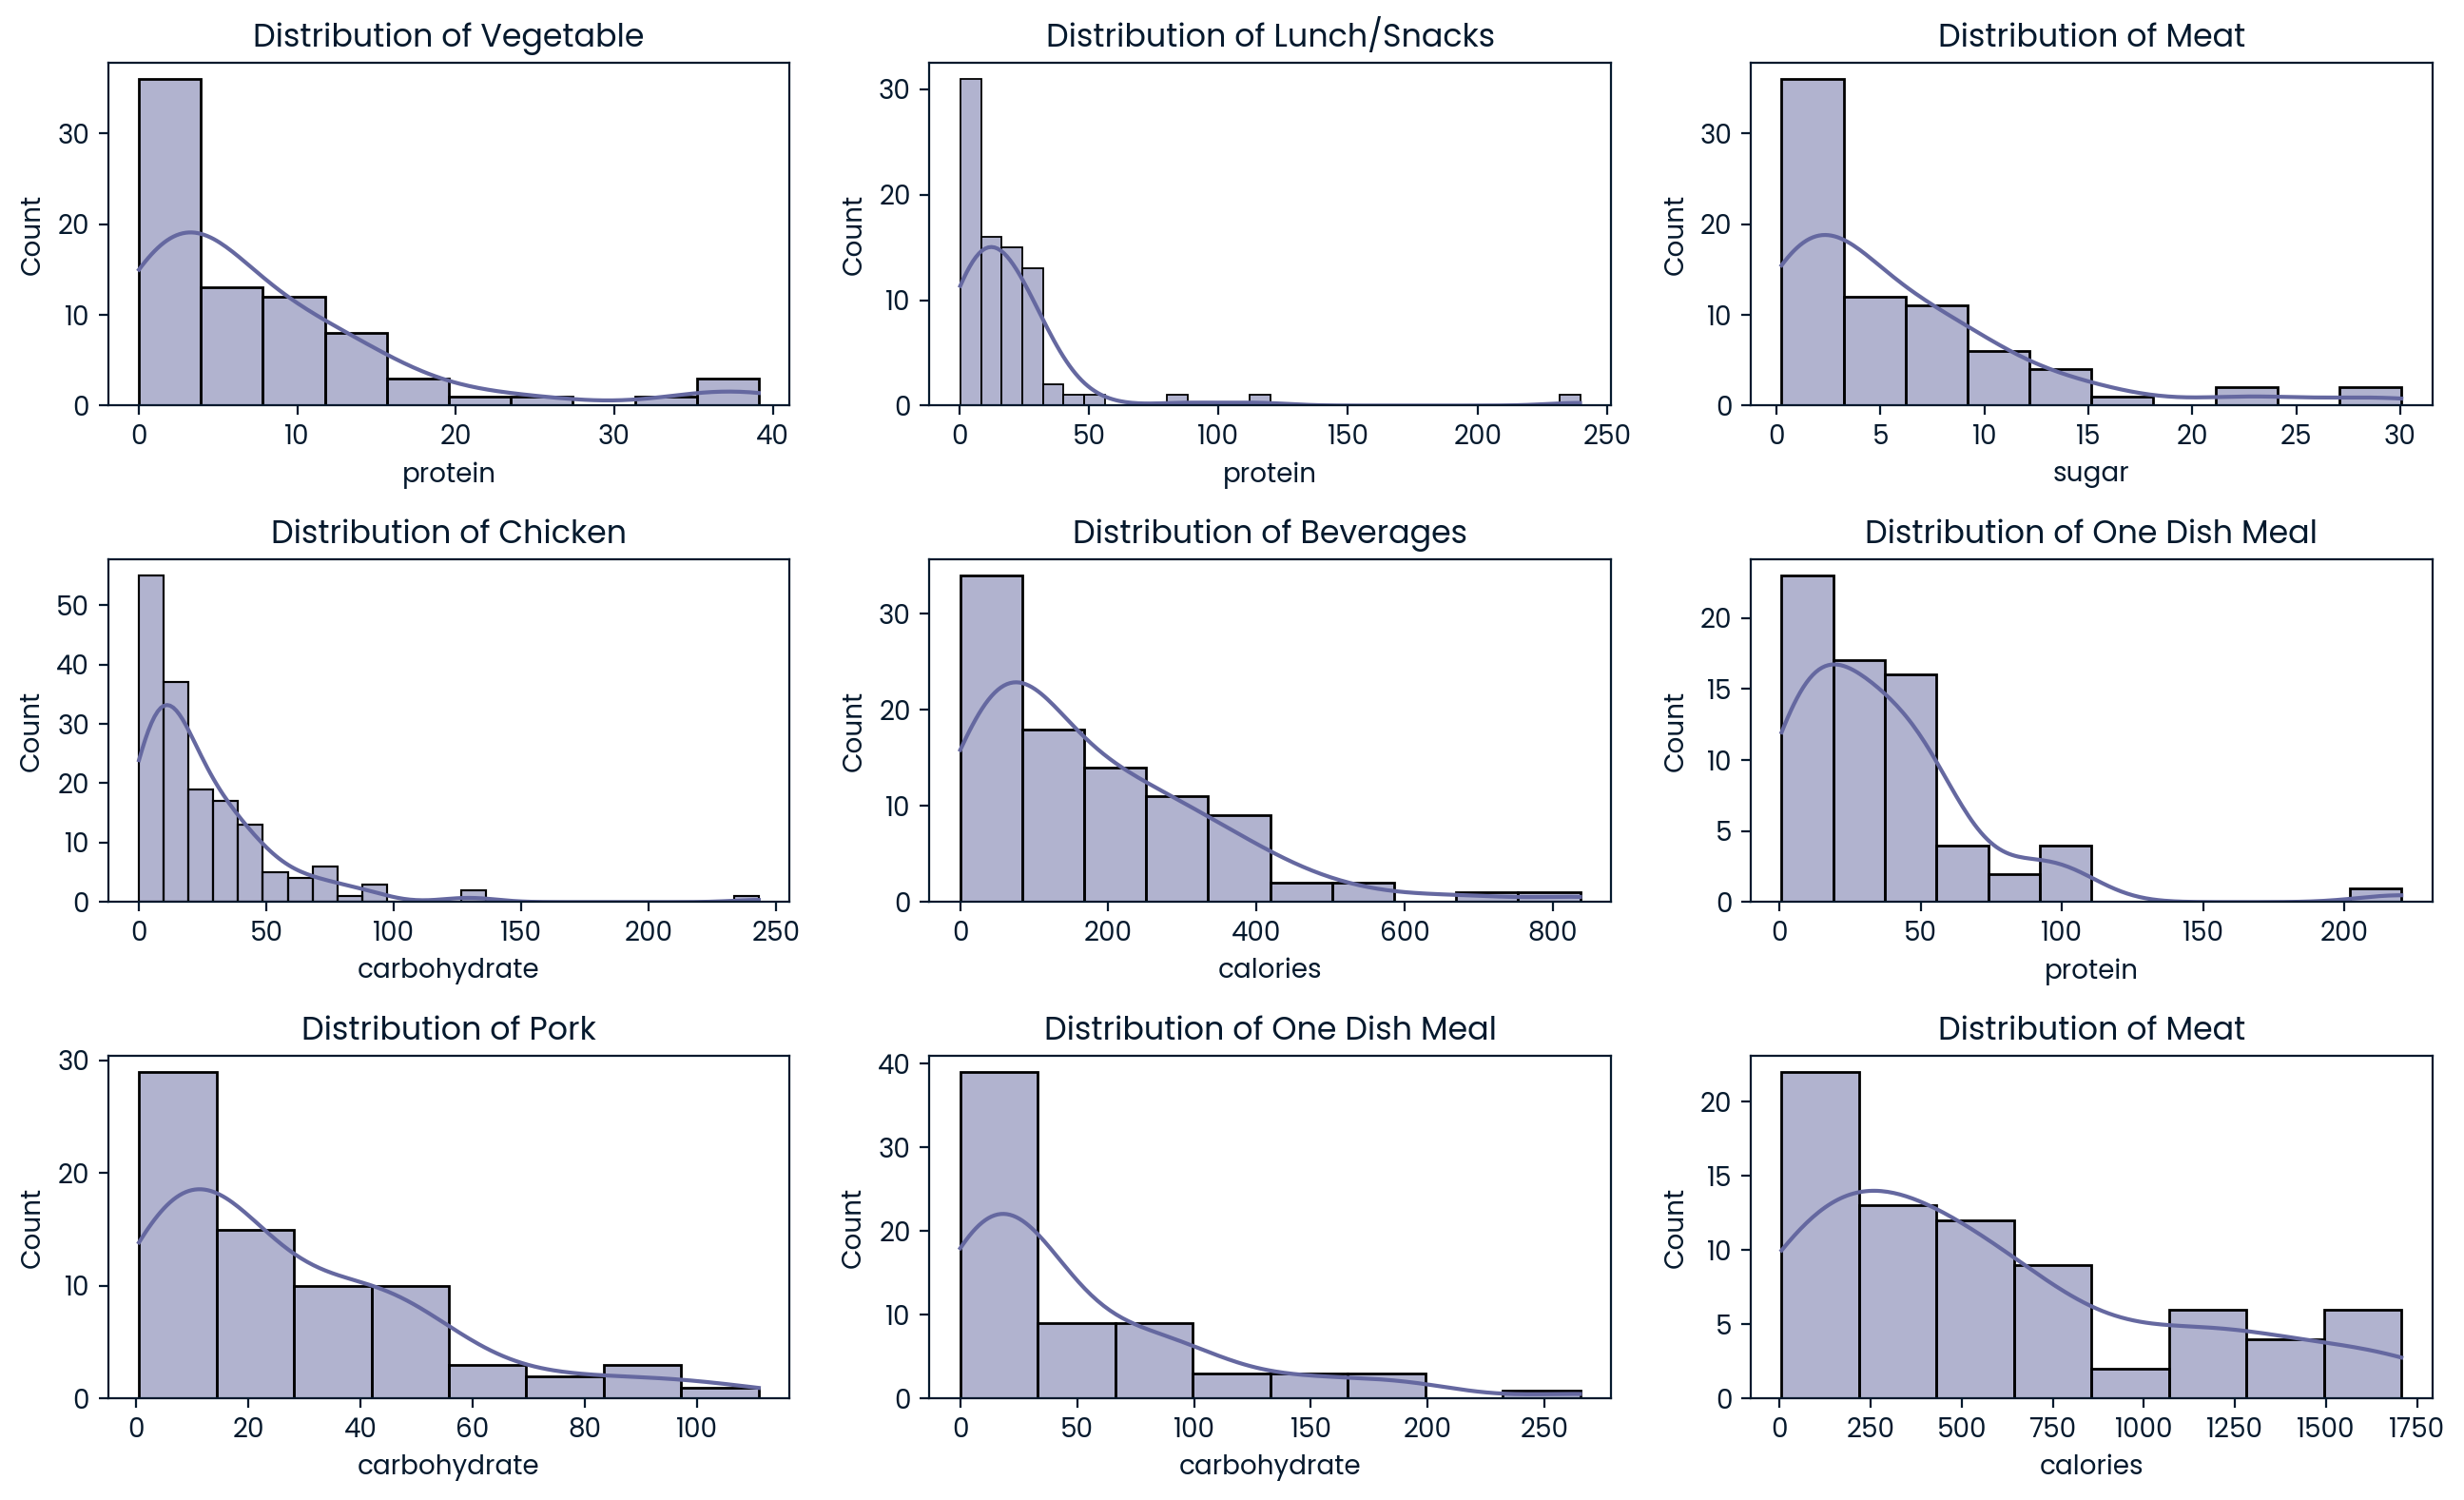

In [163]:
# Create a figure and 11 subplots (arranged in 3 rows and 3 columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 8))

# Flatten the axes for easier iteration (3x3 grid has 9 subplots)
axes = axes.flatten()

# Plot each category
for i, pair in enumerate(random_pairs):
    if i < 9:  # Ensure only 9 plots are made
        sns.histplot(df[df.category == pair[1]][pair[0]], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {pair[1]}')

plt.tight_layout()
plt.show()

In [164]:
# Fill missing values in calories, carbohydrates, sugar and protein with the median for each category
df[['calories', 'carbohydrate', 'sugar', 'protein']] = (
    df.groupby('category')[['calories', 'carbohydrate', 'sugar', 'protein']]
    .transform(lambda x: x.fillna(x.median()))
)

Looking at the distribution plots, we can see that all of them have long tails on the right, indicating that the data is skewed. This was also confirmed by the .skew() function. For this reason, we chose to fill the missing values with the median instead of the mean, as the mean could be influenced by outliers.

# Exploratory analysis

First, let's create a pairplot to visualize how the data interacts and potentially gain some insights.



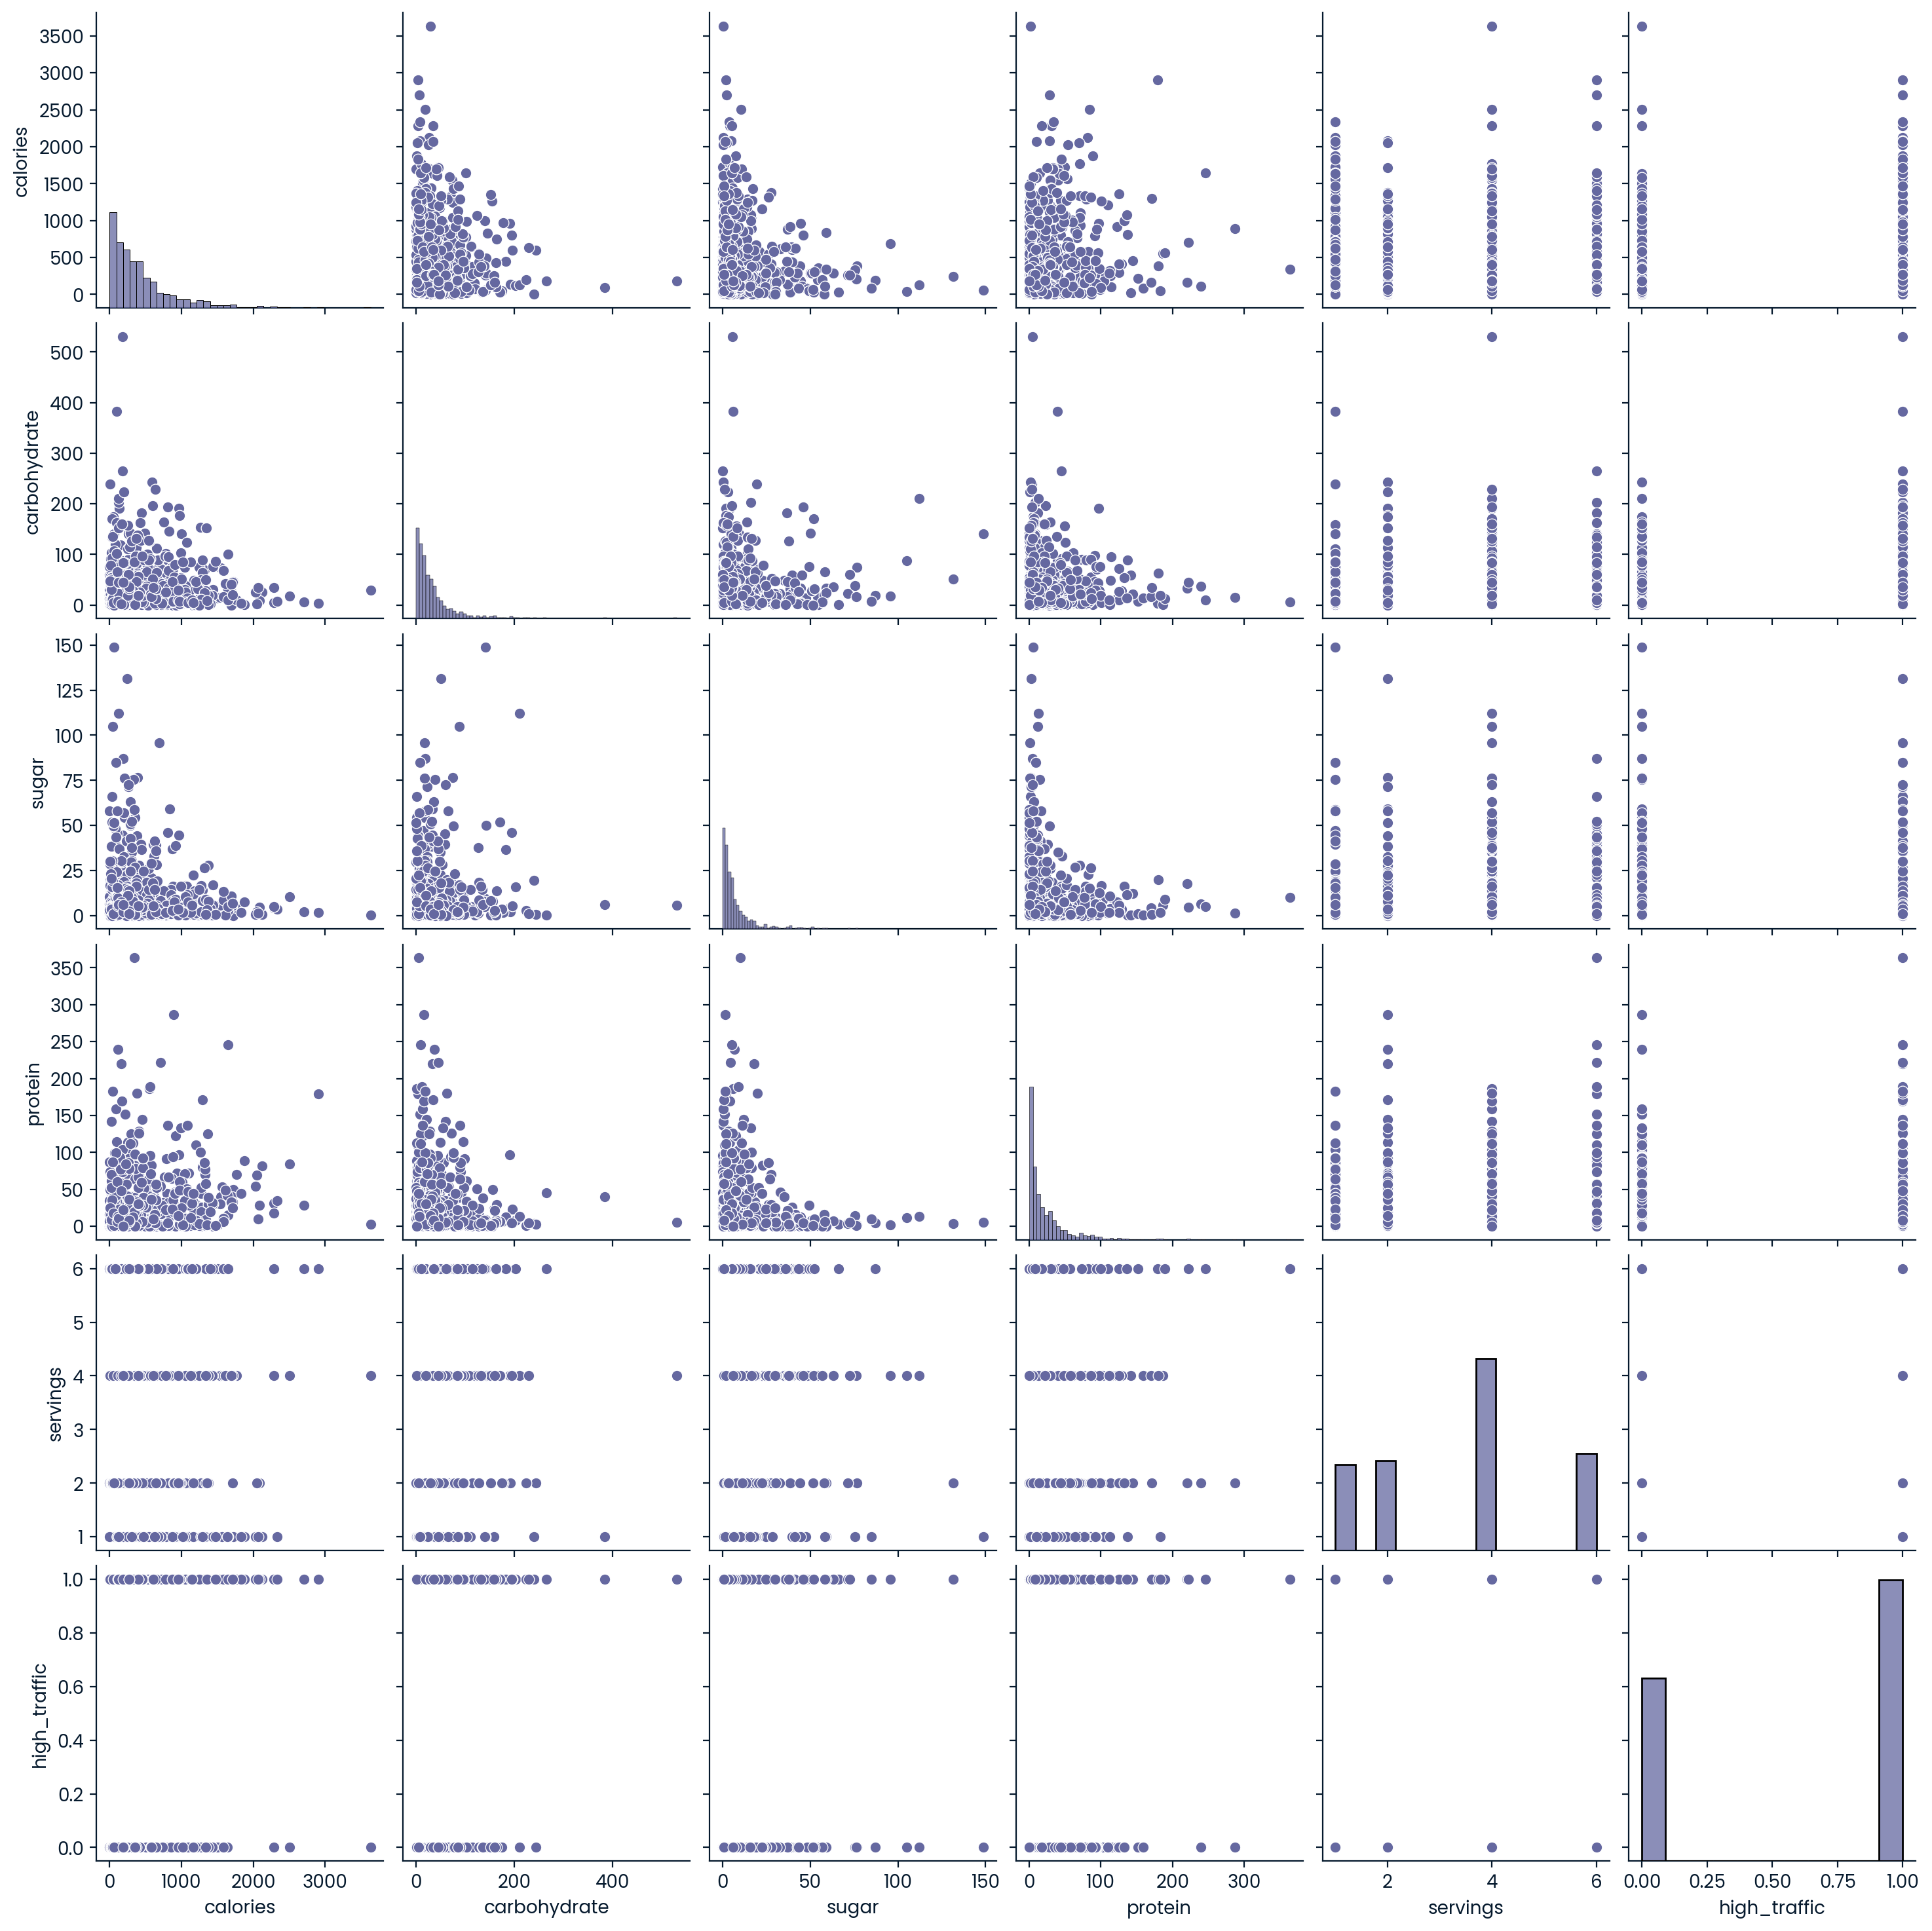

In [165]:
sns.pairplot(df)
plt.show()

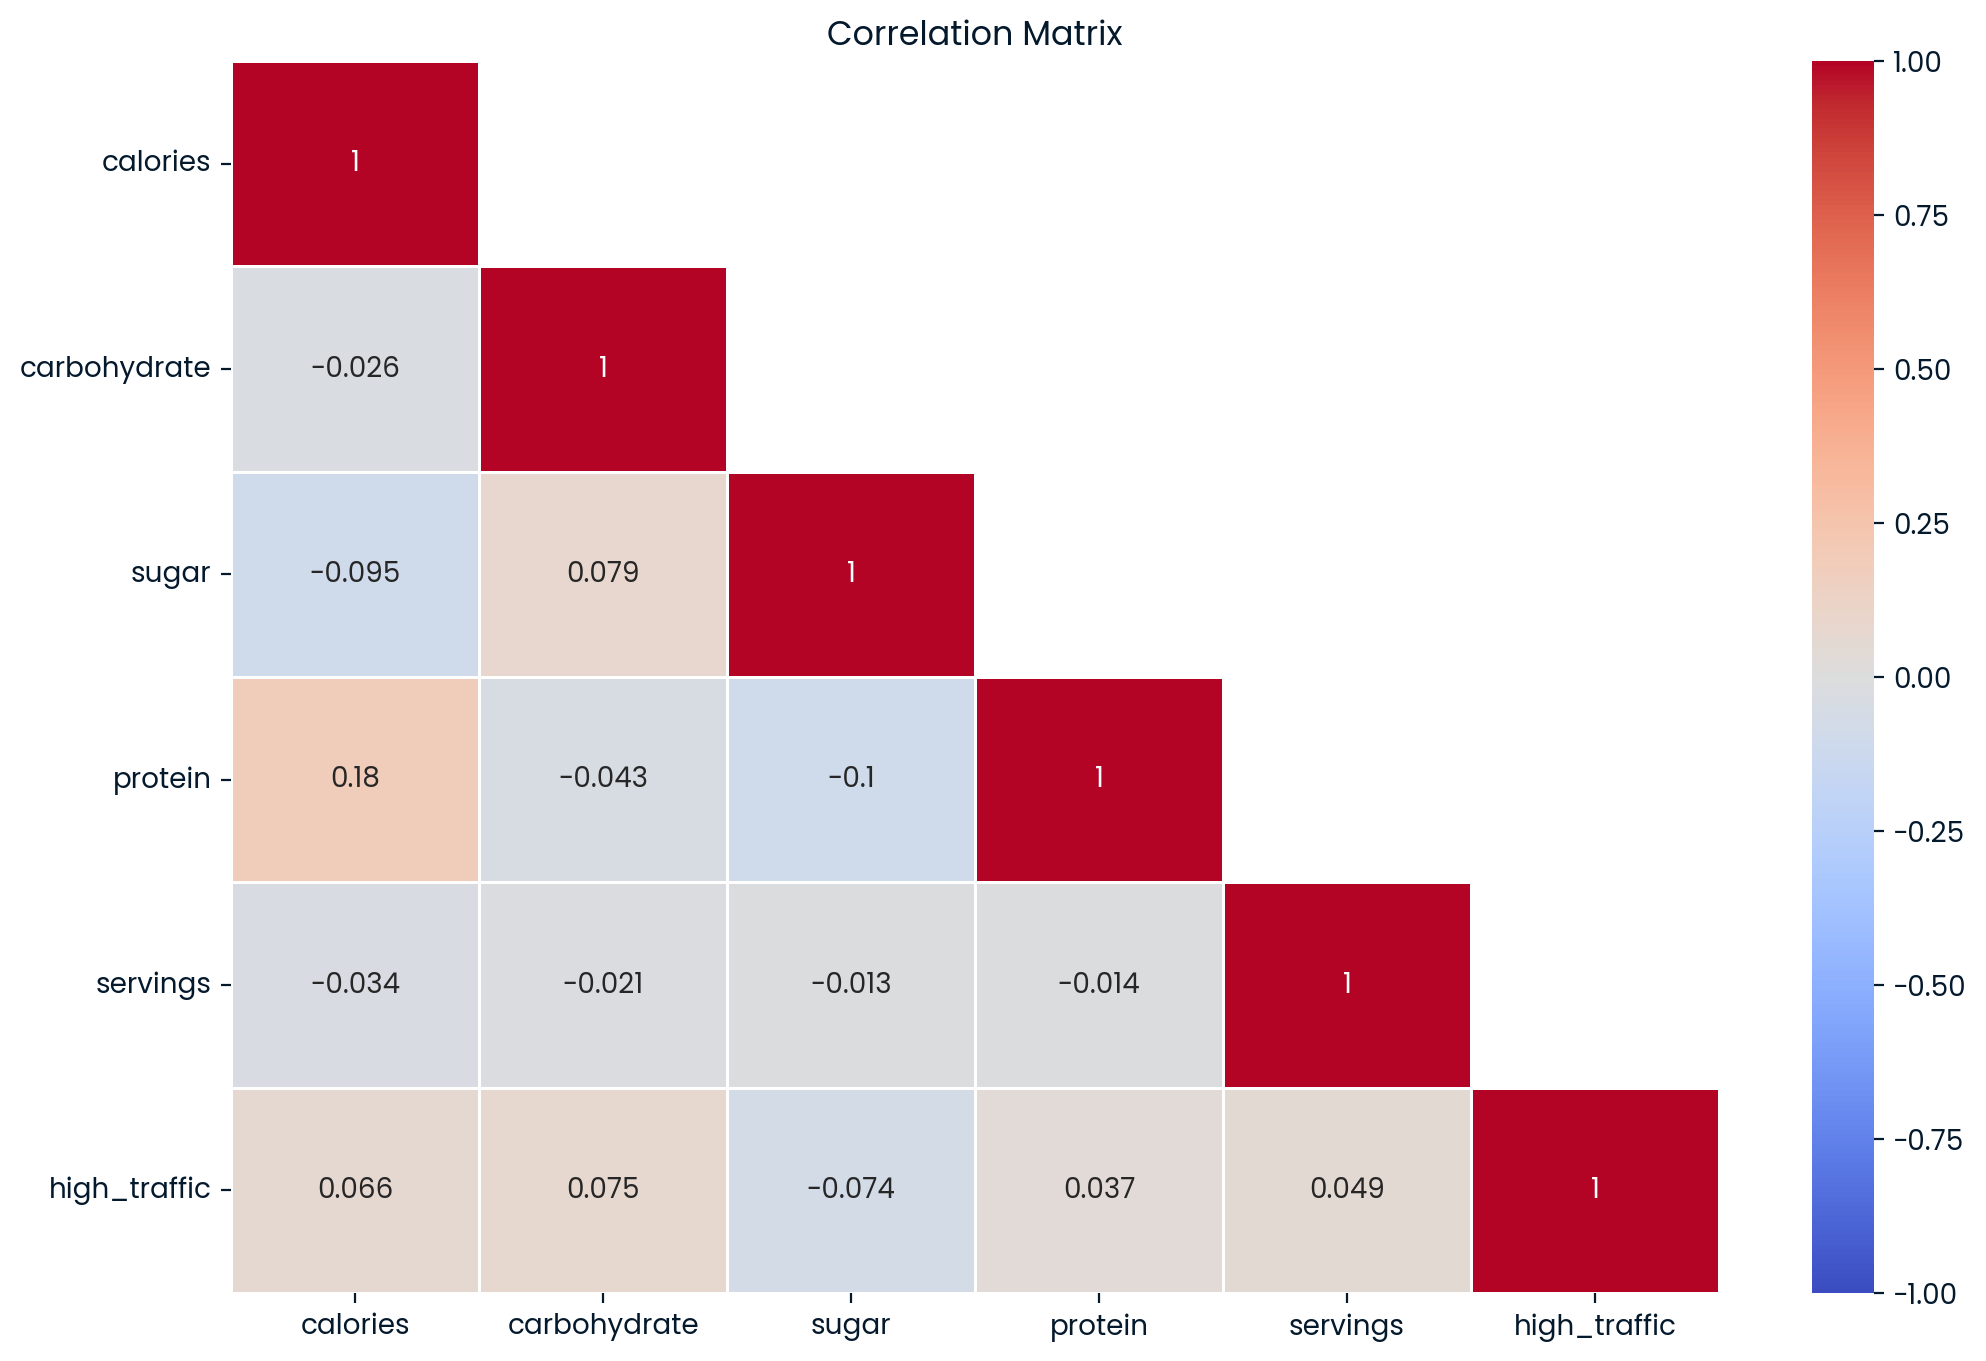

In [166]:
# Compute correlation matrix
corr_matrix = df.corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                      linewidths=0.5, vmin=-1, vmax=1, mask=mask)

# Customize the y-axis tick labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

# Add title
plt.title('Correlation Matrix')

# Display the plot
plt.show()

At first glance, it appears that the variables are neither linearly nor polynomially correlated. This is a good sign because when variables are independent or uncorrelated, they often provide unique information about the target variable. This could be beneficial, as it suggests we may have diverse and potentially useful predictors.

However, we have noticed that our nutritional information is skewed. Let's apply a log scale to see if any correlations become more evident.

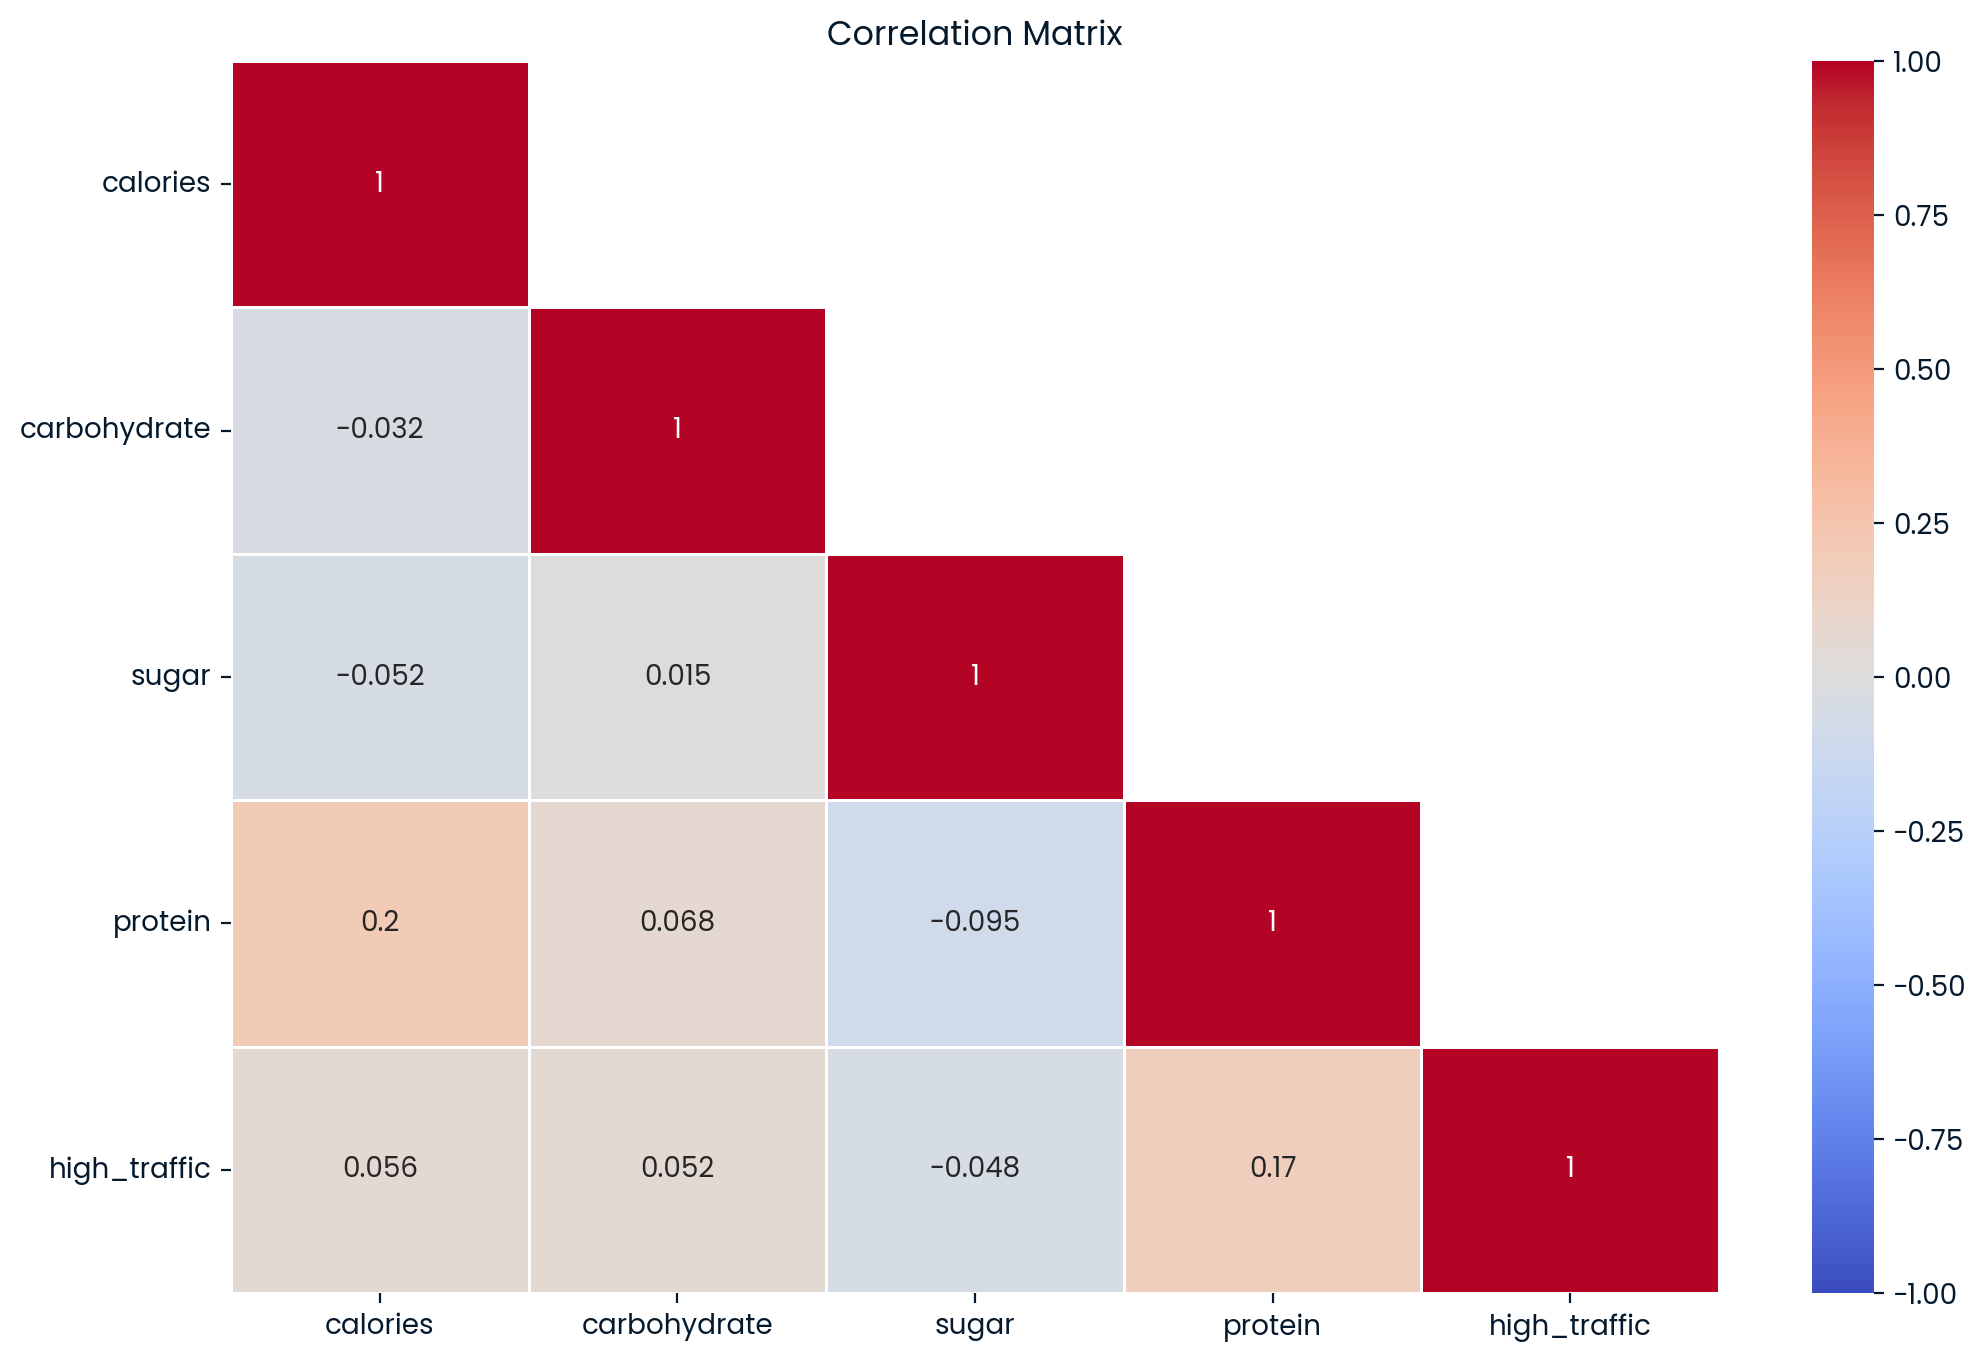

In [167]:
nutritional_df = df[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']].copy() # Now nutritional_df is an independent copy of selected columns form df

# Apply np.log only to the specified columns
nutritional_df[['calories', 'carbohydrate', 'sugar', 'protein']] = nutritional_df[['calories', 'carbohydrate', 'sugar', 'protein']].apply(np.log)

# Replace -inf values with NaN (log(0) produces -inf)
nutritional_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (either from -inf or from actual NaN)
nutritional_df = nutritional_df.dropna()

# Compute correlation matrix
corr_matrix_log = nutritional_df.corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix_log, dtype=bool), k=1)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
heatmap = sns.heatmap(corr_matrix_log, annot=True, cmap='coolwarm', center=0, 
                      linewidths=0.5, vmin=-1, vmax=1, mask=mask)

# Customize the y-axis tick labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

# Add title
plt.title('Correlation Matrix')

# Display the plot
plt.show()

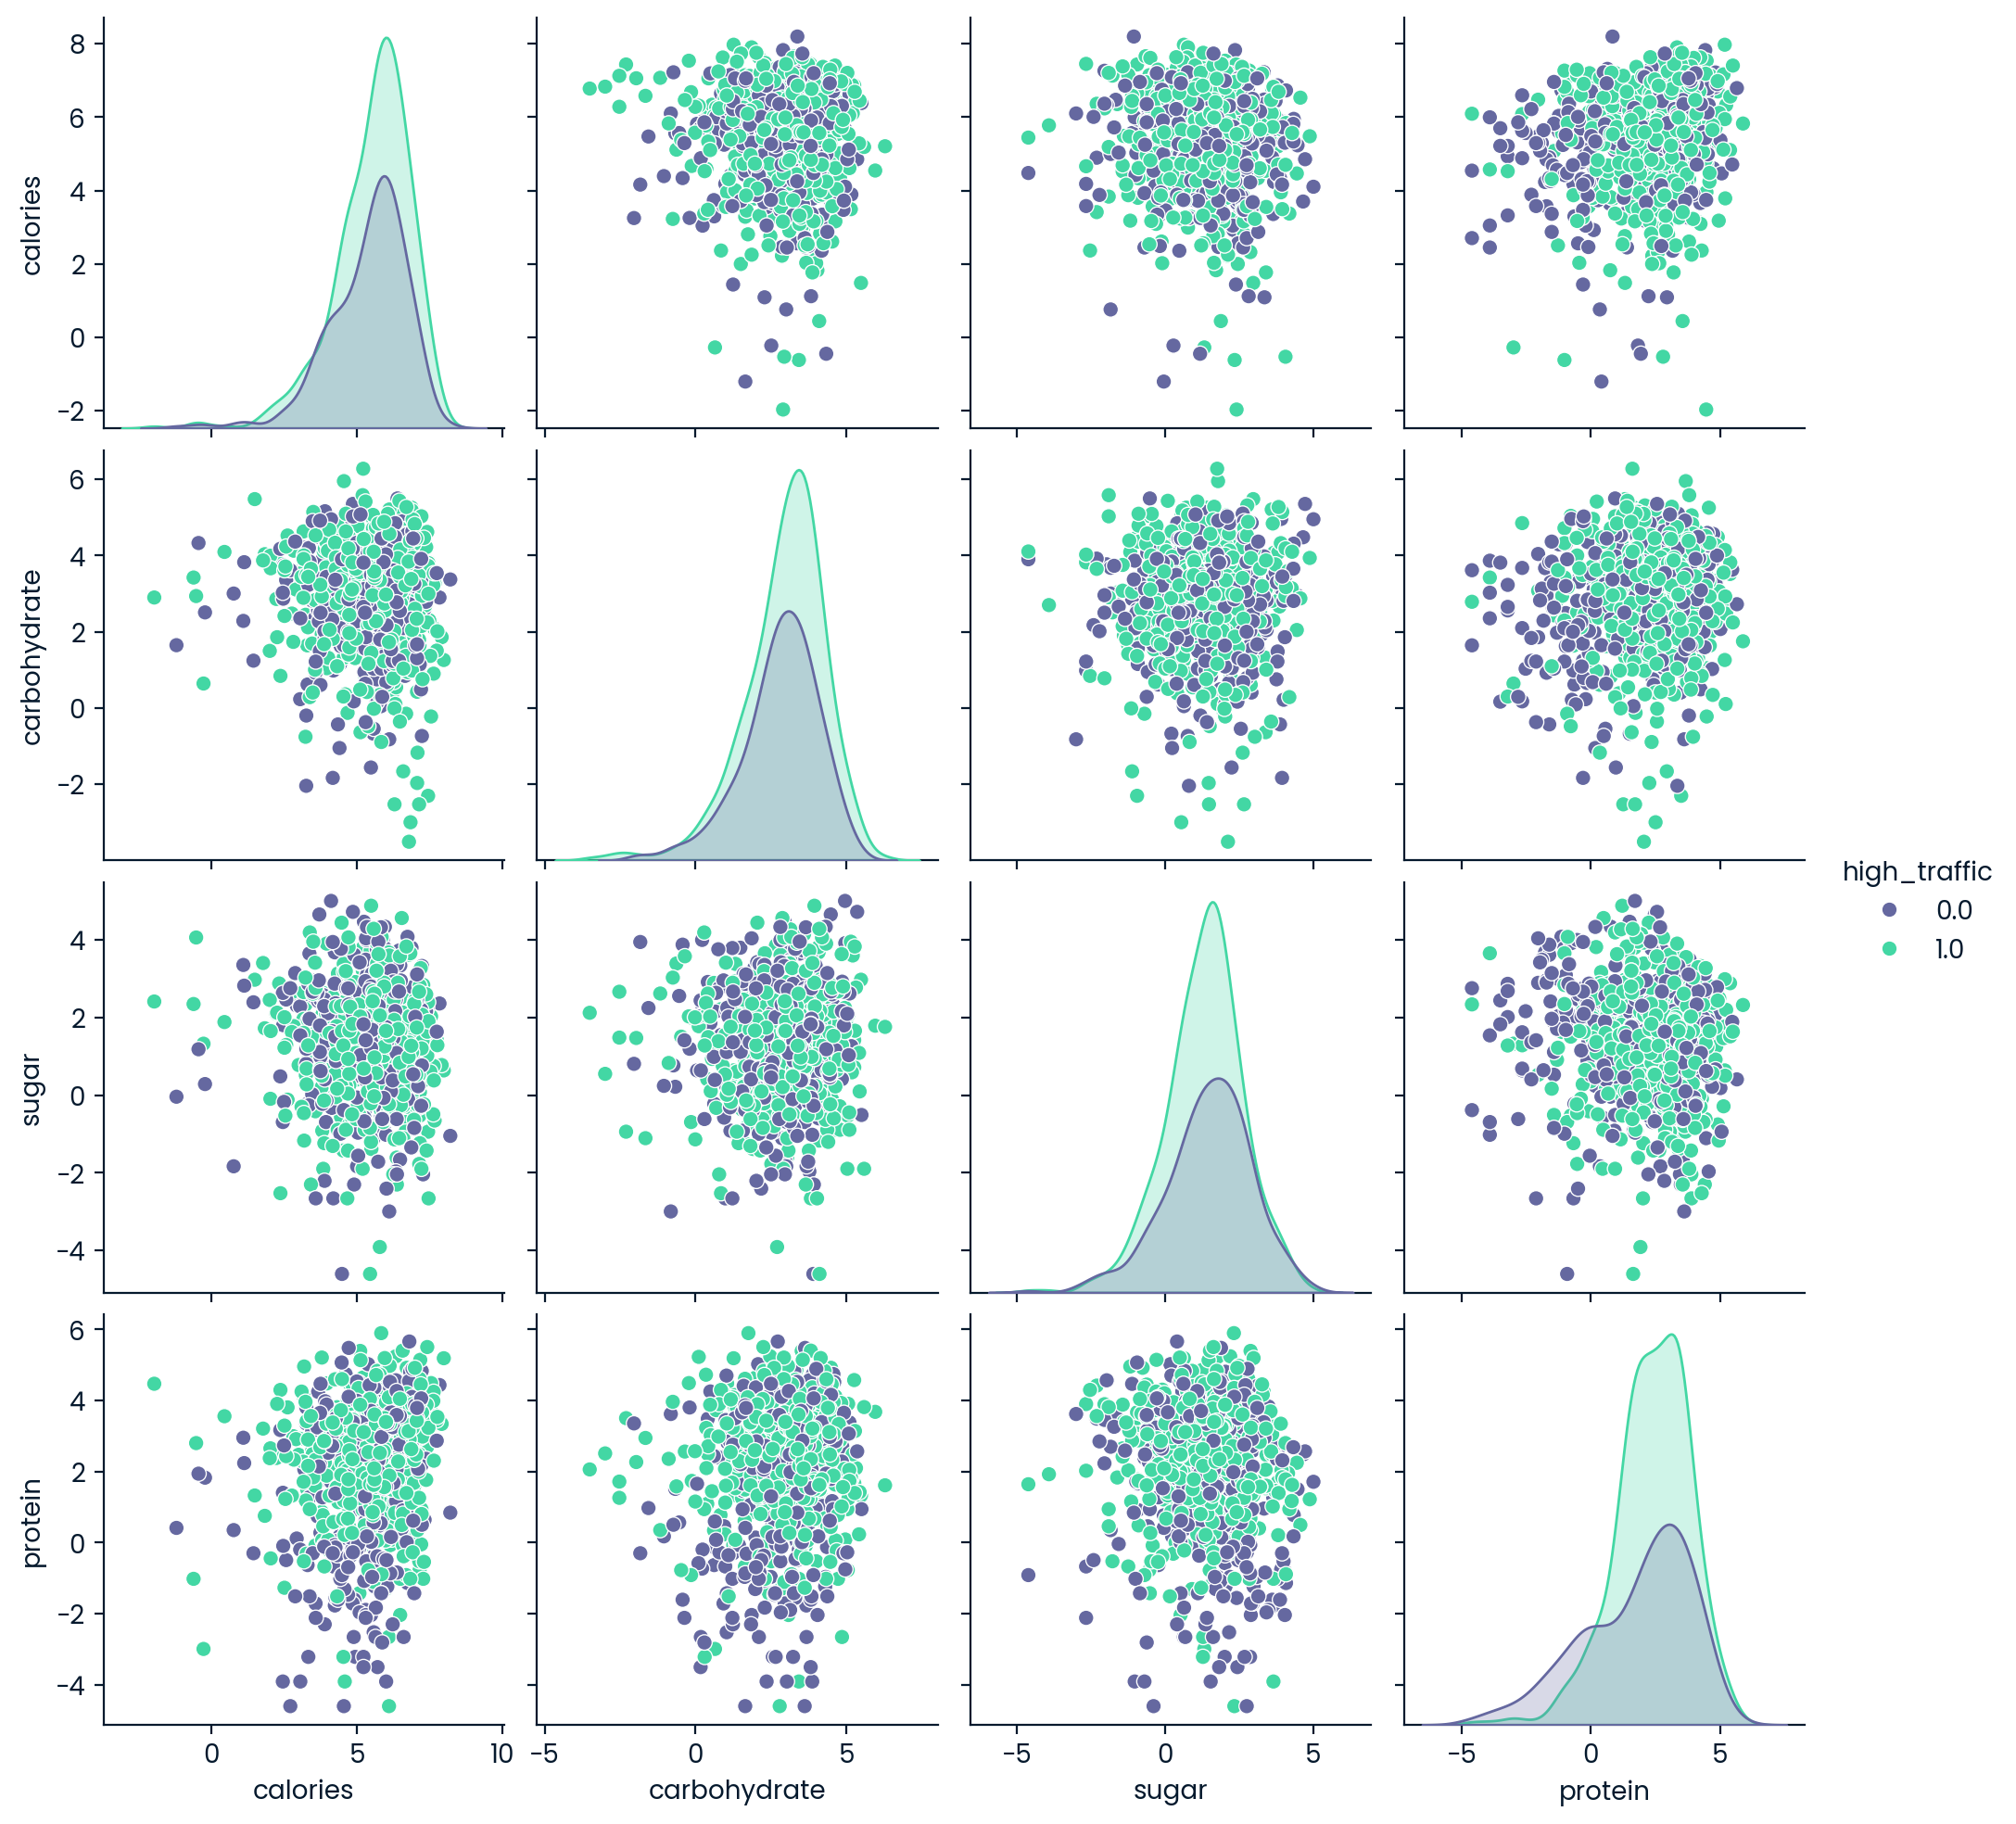

In [168]:
sns.pairplot(nutritional_df, hue='high_traffic')
plt.show()

After transforming the nutritional data using the natural logarithm and generating a heatmap and pairplot, we still don't observe any clear relationships between the variables. Additionally, when creating the pairplot with the hue set to our target variable, it's challenging to draw any conclusions about whether high-traffic and low-traffic recipes behave differently in relation to the nutritional variables.

Let's use boxplots to take a closer look at whether high-traffic recipes have a different distribution in the nutritional columns.

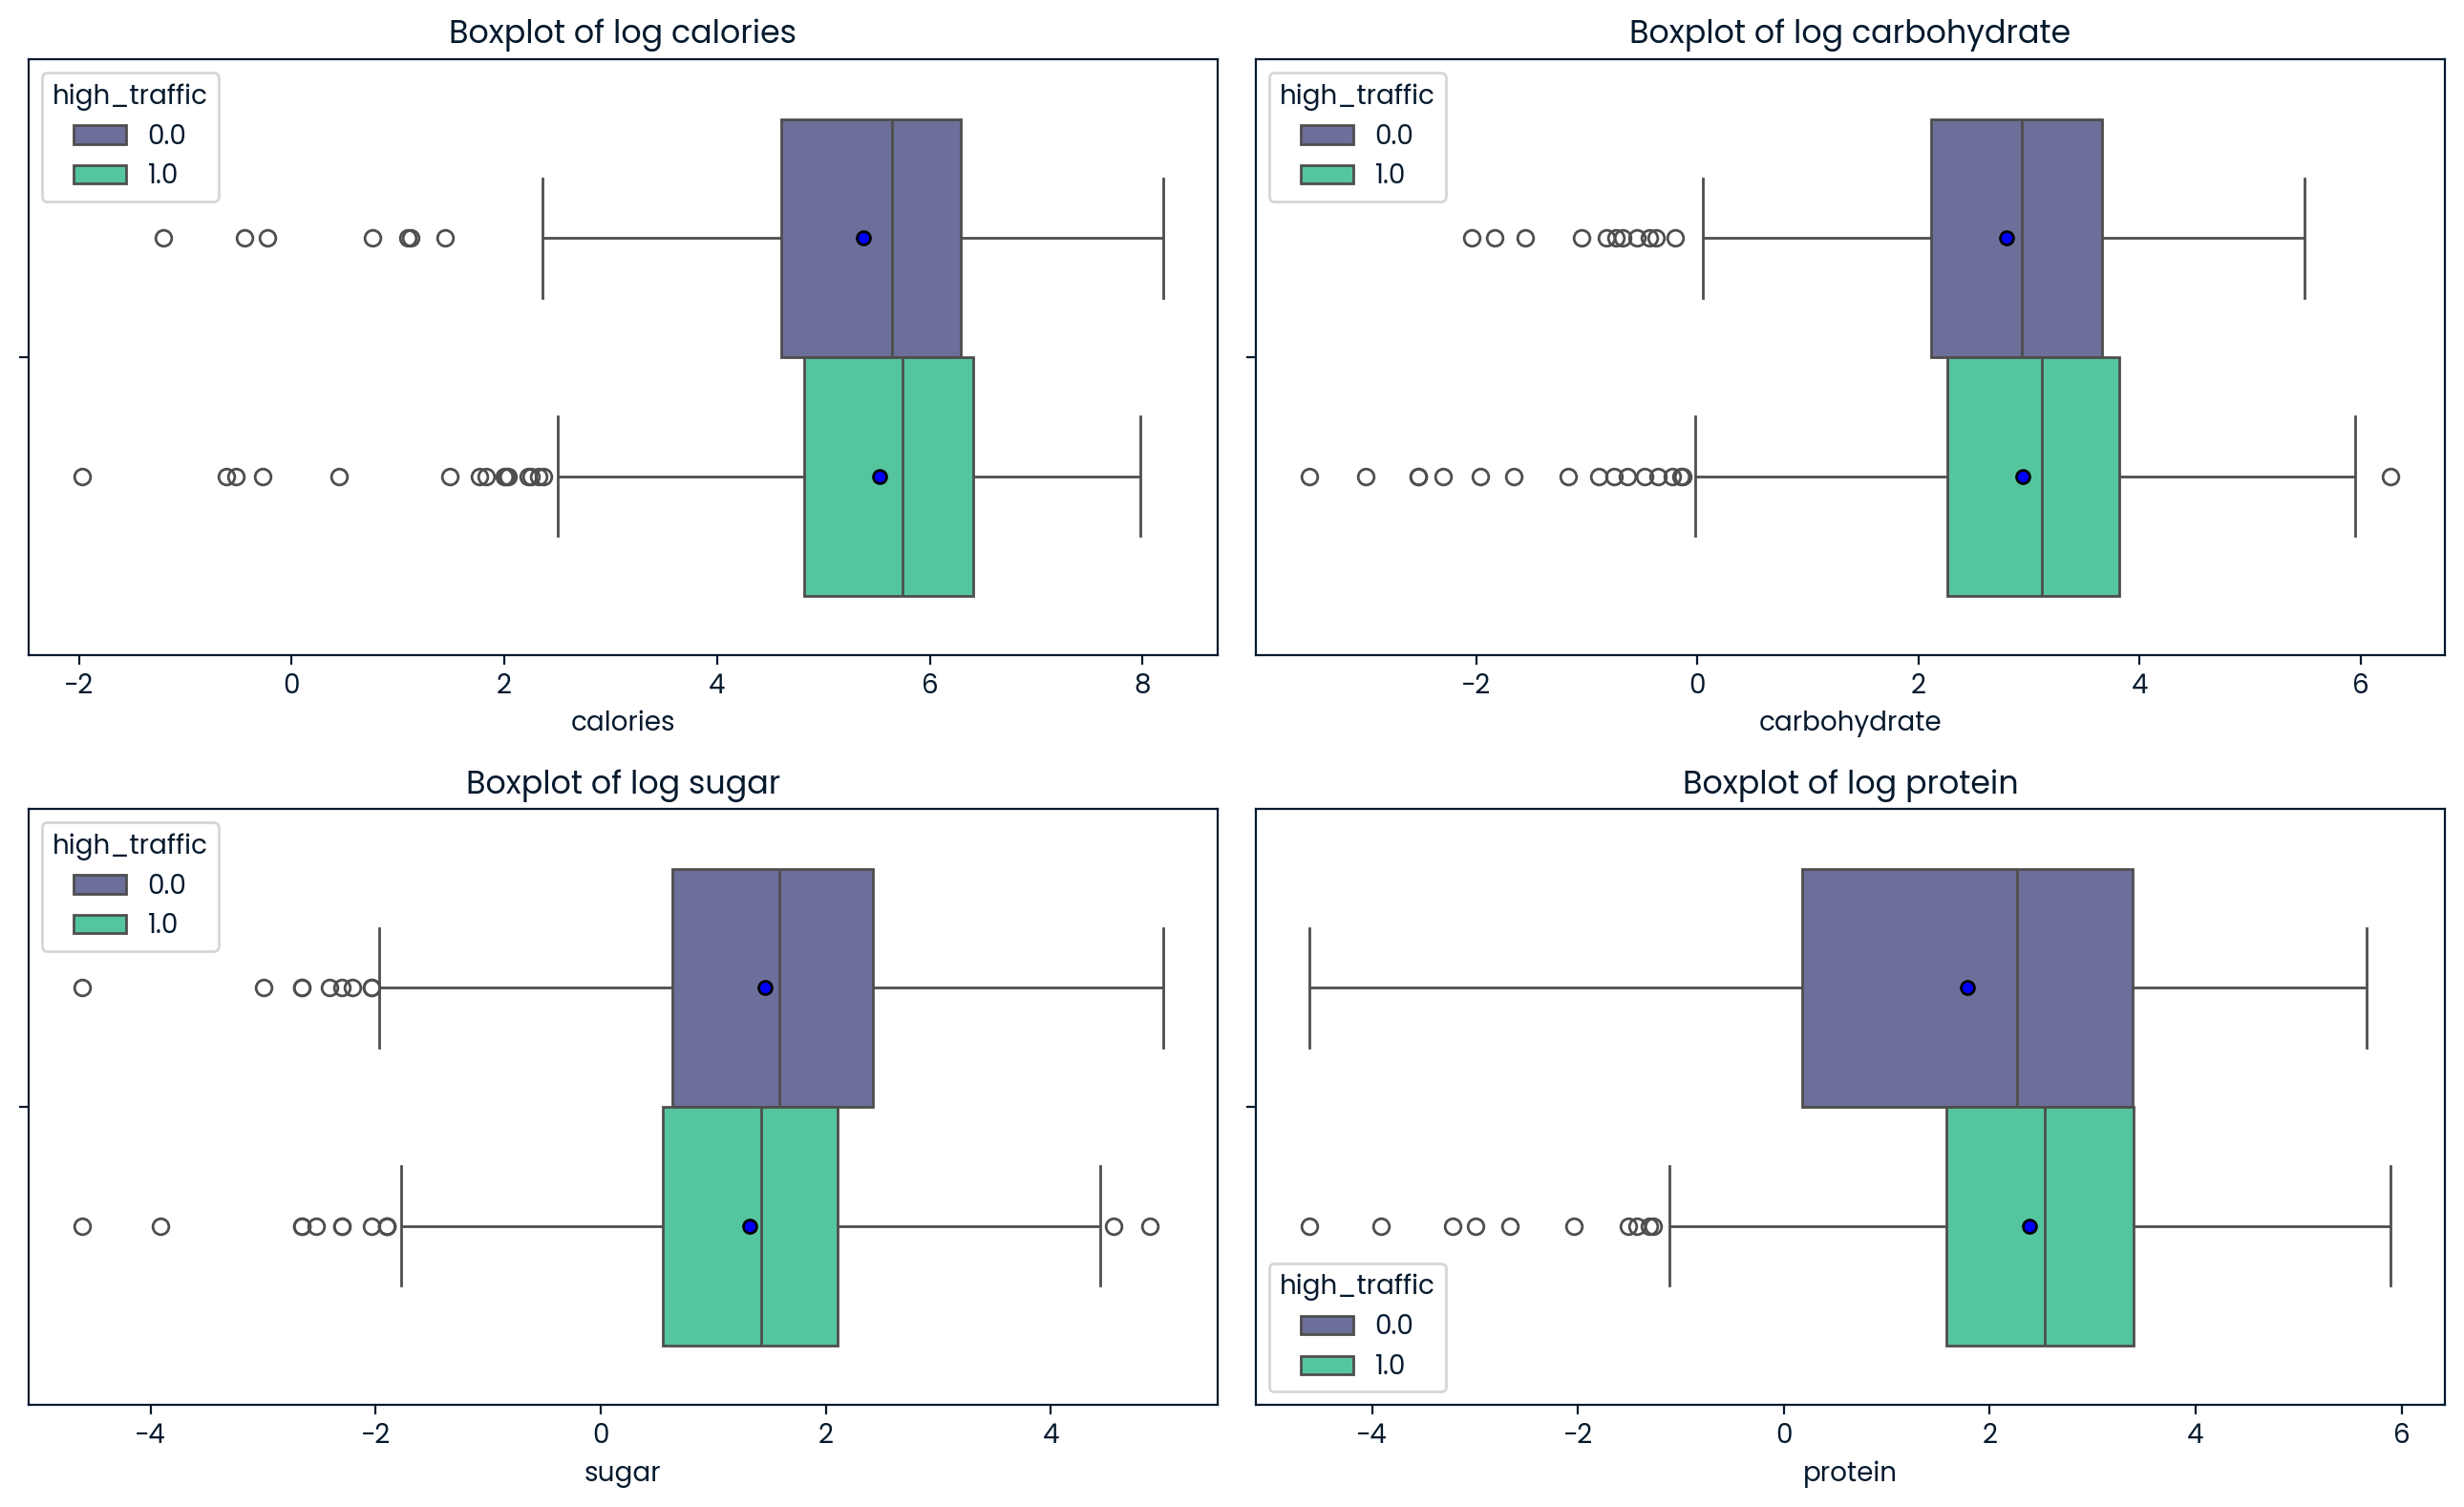

In [169]:
# Create a figure and 4 subplots (arranged in 2 rows and 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

# Flatten the axes for easier iteration (2x2 grid has 4 subplots)
axes = axes.flatten()

# Customizing the mean marker
meanprops = {
    "marker": "o",  # Marker style
    "markerfacecolor": "blue",  # Fill color of the marker
    "markeredgecolor": "black",  # Edge color of the marker
    "markersize": 5,  # Size of the marker
}

# Plot each category
for i, column in enumerate(num_columns):
    if i < 4:  # Ensure only 4 plots are made
        sns.boxplot(data=nutritional_df, x=nutritional_df[column], ax=axes[i], hue='high_traffic', showmeans=True, meanprops=meanprops)
        axes[i].set_title(f'Boxplot of log {column}')

plt.tight_layout()
plt.show()

The boxplots suggest that recipes generating high traffic on the webpage tend to have higher calories, carbohydrates, and protein content, but lower sugar content.

Finally, let's investigate if there is a preferred quantity of servings.

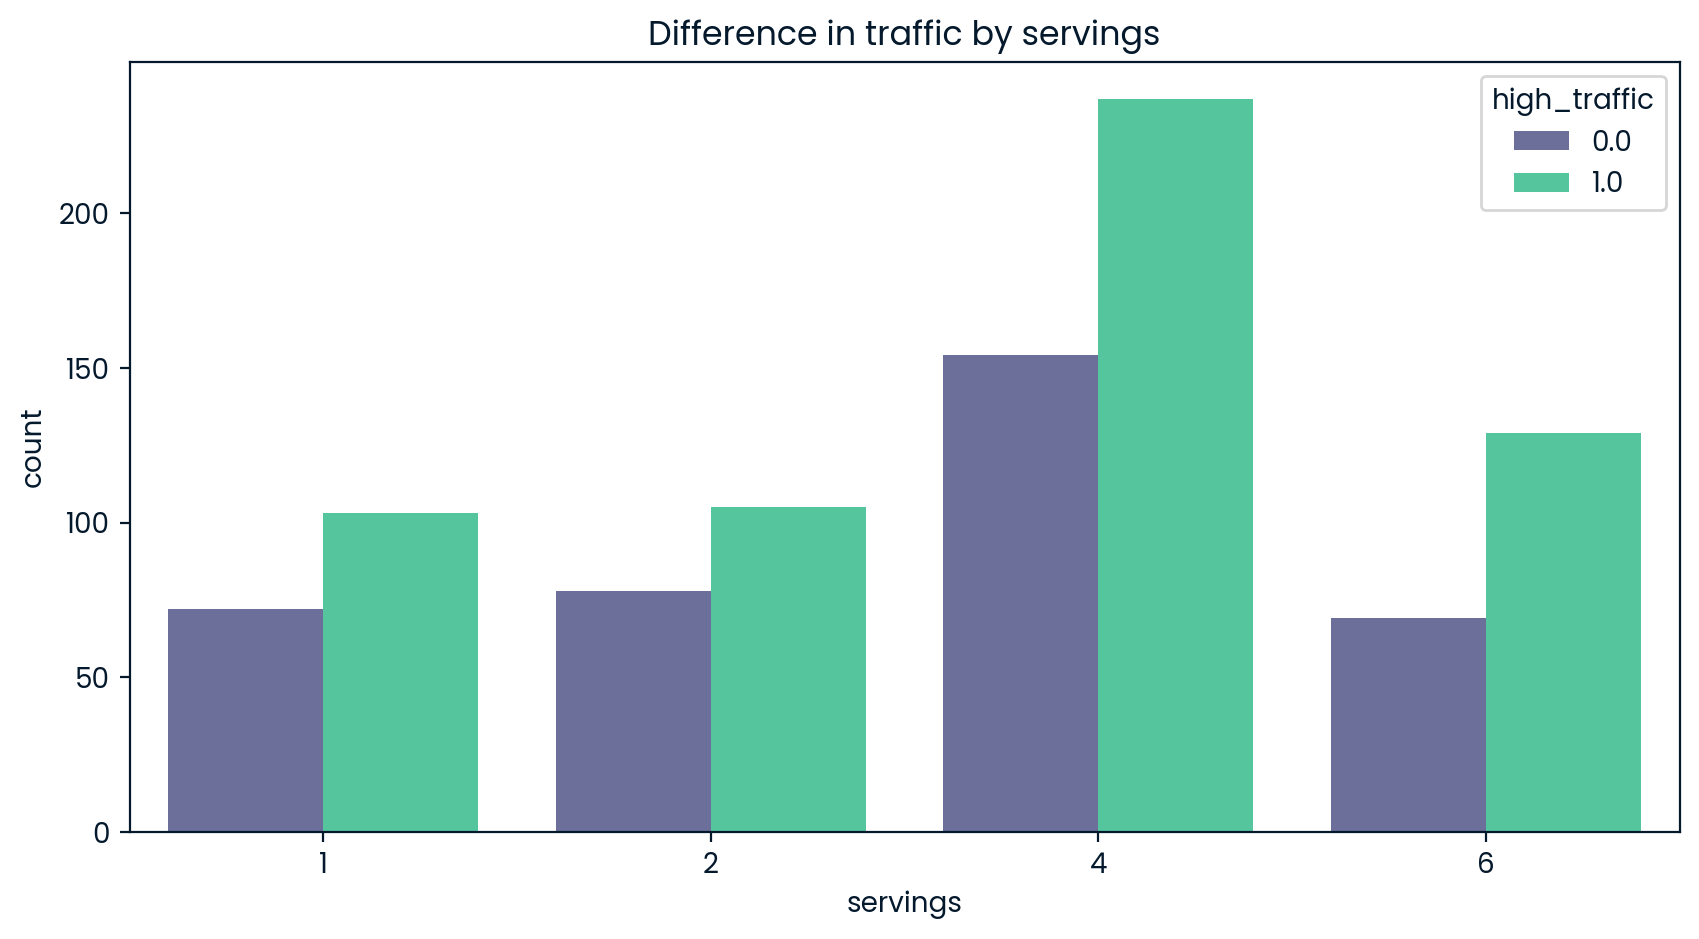

In [170]:
# Set up the figure size
plt.figure(figsize=(10, 5))

# Create a count plot with 'servings' on x-axis and 'high_traffic' as the hue
sns.countplot(x='servings', hue='high_traffic', data=df)

plt.title('Difference in traffic by servings')
plt.show()

From the graph above, we can observe that the gap between high-traffic and low-traffic recipes is more pronounced in recipes for 4 and 6 servings.



# Model Development

Our objective is to predict which recipes will be popular, or in other words, which recipes will generate higher traffic on the webpage. This makes our task a binary classification problem. We will use three models: linear regression, support vector machines (SVM), and random forest classifier. Linear regression will help capture any linear correlations, while SVM is capable of handling both linear and non-linear relationships. The random forest classifier, composed of decision trees, is well-suited for non-linear patterns.

Since our dataset is slightly imbalanced, with about 60% of recipes producing high traffic and 40% generating low traffic, we will focus on the precision metric and F1 score. Although the F1 score is useful as it takes the harmonic mean of precision and recall, balancing the correct prediction of both positive and negative classes (high-traffic and low-traffic recipes), we will prioritize precision in our tuning and training.

By focusing on precision, we aim to develop models that accurately predict high-traffic recipes, minimizing false positives. However, this approach might lead to more high-traffic recipes being incorrectly classified as low-traffic. To mitigate this, we'll rely on the F1 score as a secondary metric to maintain a good balance between precision and recall. Additionally, we will calculate accuracy for informational purposes, though it is less relevant than F1 and precision in this scenario.

In [171]:
# Splitting DataFrame into target column and features columns.
X = df.drop(['high_traffic'], axis=1)
y = df['high_traffic']

# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111, stratify=y)

After splitting our data into training and testing datasets, we will create encoder for our categorical variables to make them suitable for machine learning models.



In [172]:
# Define the preprocessing pipeline
preprocessor_encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['category']),
        ('num', 'passthrough', ['calories', 'carbohydrate', 'sugar', 'protein', 'servings'])  # We passthrough other numeric columns
    ]
)

Before training our more complex models, let's create a few simple dummy classifiers to see what results they generate. Our objective will be to develop models that perform better than these dummy classifiers. We will use three types of dummy classifiers:

- Most Frequent: This classifier predicts the most frequent outcome, which in our case is high traffic.
- Stratified: This classifier generates balanced outcomes based on the distribution of the target variable.
- Random: This classifier makes predictions randomly.

In [173]:
# 1. Most Frequent Dummy Classifier
# Pipeline combining preprocessing and model
dummy_most_fre_pipeline = Pipeline([
    ('preprocessor', preprocessor_encoder),
    ('dummy_most_fre', DummyClassifier(strategy="most_frequent", random_state=111))  # Simple dummy classifier (most frequent)
])

# Fit the simple model
dummy_most_fre_pipeline.fit(X_train, y_train)

y_pred_most_frequent = dummy_most_fre_pipeline.predict(X_test)
print("Precision (Most Frequent):", precision_score(y_test, y_pred_most_frequent).round(3))
print("F1 Score (Most Frequent):", f1_score(y_test, y_pred_most_frequent).round(3))
print("Accuracy (Most Frequent):", accuracy_score(y_test, y_pred_most_frequent).round(3))


Precision (Most Frequent): 0.608
F1 Score (Most Frequent): 0.756
Accuracy (Most Frequent): 0.608


In [174]:
# 2. Stratified Dummy Classifier
# Pipeline combining preprocessing and model
dummy_strat_pipeline = Pipeline([
    ('preprocessor', preprocessor_encoder),
    ('dummy_strat', DummyClassifier(strategy="stratified", random_state=111))  # Simple dummy classifier (Stratified)
])

# Fit the simple model
dummy_strat_pipeline.fit(X_train, y_train)

y_pred_stratified = dummy_strat_pipeline.predict(X_test)
print("Precision (Stratified):", precision_score(y_test, y_pred_stratified).round(3))
print("F1 Score (Stratified):", f1_score(y_test, y_pred_stratified).round(3))
print("Accuracy (Stratified):", accuracy_score(y_test, y_pred_stratified).round(3))


Precision (Stratified): 0.574
F1 Score (Stratified): 0.568
Accuracy (Stratified): 0.481


In [175]:
# 3. Uniform (Random) Dummy Classifier
# Pipeline combining preprocessing and model
dummy_random_pipeline = Pipeline([
    ('preprocessor', preprocessor_encoder),
    ('dummy_random', DummyClassifier(strategy="uniform", random_state=111))  # Simple dummy classifier (Random)
])

# Fit the simple model
dummy_random_pipeline.fit(X_train, y_train)

y_pred_random = dummy_random_pipeline.predict(X_test)
print("Precision (Random):", precision_score(y_test, y_pred_random).round(3))
print("F1 Score (Random):", f1_score(y_test, y_pred_random).round(3))
print("Accuracy (Random):", accuracy_score(y_test, y_pred_random).round(3))


Precision (Random): 0.606
F1 Score (Random): 0.522
Accuracy (Random): 0.489


Based on the results above, our objective will be to create models that achieve an F1 score higher than 0.76 and a precision greater than 0.61.

Since we will be using linear regression and SVM, it's good practice to scale the data. In our case, we should also transform the data using logarithms, as we have skewed values in the nutritional columns. However, before applying the logarithm, we need to ensure that we replace the 0 values in the protein column (as detected in the describe method) with non-zero values. We will replace these 0 values with the next smallest non-zero value in the protein column. By doing this, we avoid issues with taking the logarithm of zero (which is undefined) while still preserving the distribution of the data.



In [176]:
# Define the custom log transformation function
def log_transform(X):
    # Replace zeros with a small non-zero value
    min_non_zero = X[X > 0].min()
    return np.log(X.replace(0, min_non_zero))

# Create the preprocessing pipeline
preprocessor_log_scale = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('log', FunctionTransformer(func=log_transform, validate=False)),  # Log transform
            ('scaler', StandardScaler())  # Scale the numerical features
        ]), ['calories', 'carbohydrate', 'sugar', 'protein']),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['category']),
        ('serv', 'passthrough', ['servings'])
    ]
)


Once the transformer is ready, we can apply it to models like logistic regression and SVM. However, for the random forest classifier, we will use a preprocessor that only encodes the categorical columns, since random forests do not require scaling or transformations of numerical data.

In [177]:
# Initialize simple log_reg model
simple_log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor_log_scale),
    ('log_reg', LogisticRegression(random_state=123))  
])

# Train the model
simple_log_reg_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_log_reg = simple_log_reg_pipeline.predict(X_test)

# Evaluate the model
precision_log_reg = precision_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print("Logistic Regression Precision:", precision_log_reg)
print("Logistic Regression F1 Score:", f1_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

Logistic Regression Precision: 0.7806451612903226
Logistic Regression F1 Score: 0.8093645484949832
Logistic Regression Accuracy: 0.759493670886076


In [178]:
# Initialize simple SVM model
simple_svm_pipeline = Pipeline([
    ('preprocessor', preprocessor_log_scale),
    ('svm', SVC(kernel='rbf', random_state=123)) 
])

# Train the model
simple_svm_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_svm = simple_svm_pipeline.predict(X_test)

# Evaluate the model
precision_svm = precision_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("Support Vector Machine Precision:", precision_svm)
print("Support Vector Machine F1 Score:", f1_svm)
print("Support Vector Machine Accuracy:", accuracy_svm)

Support Vector Machine Precision: 0.7672955974842768
Support Vector Machine F1 Score: 0.8052805280528054
Support Vector Machine Accuracy: 0.7510548523206751


In [179]:
# Initialize simple Random Forest model
simple_rfc_pipeline = Pipeline([
    ('preprocessor', preprocessor_encoder),
    ('rfc', RandomForestClassifier(random_state=123))
])

# Train the model
simple_rfc_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred_rfc = simple_rfc_pipeline.predict(X_test)

# Evaluate the model
precision_rfc = precision_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)

print("Random Forest Precision:", precision_rfc)
print("Random Forest F1 Score:", f1_rfc)
print("Random Forest Accuracy:", accuracy_rfc)

Random Forest Precision: 0.7602739726027398
Random Forest F1 Score: 0.7655172413793104
Random Forest Accuracy: 0.7130801687763713


From the results above, we can see that even without tuning, the models perform quite well, outperforming the dummy classifiers. Next, let's tune each model and see how their performance improves.

In [180]:
# Creating pipelines for each model for posterior tuning
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor_log_scale),
    ('log_reg', LogisticRegression(random_state=111))  
])

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor_log_scale),
    ('svm', SVC(random_state=122))
])

rfc_pipeline = Pipeline([
    ('preprocessor', preprocessor_encoder),
    ('rfc', RandomForestClassifier(random_state=133))
])

# Separate hyperparameter grids for each model
# 1. Define the parameter grid for logistic regression
param_grid_log_reg = [
    # For solvers that support both 'l1' and 'l2'
    {'log_reg__C': loguniform(1e-3, 1e2),
     'log_reg__penalty': ['l1', 'l2'],
     'log_reg__solver': ['liblinear', 'saga']},

    # For solvers that only support 'l2'
    {'log_reg__C': loguniform(1e-3, 1e2),
     'log_reg__penalty': ['l2'],
     'log_reg__solver': ['lbfgs']}
]

# 2. Define the parameter grid for SVM
param_grid_svm = [
    # Grid for RBF kernel
    {
        'svm__C': loguniform(1e-3, 1e2),  # Regularization strength
        'svm__kernel': ['rbf'],           # only the RBF kernel
        'svm__gamma': ['scale', 'auto'],  # Gamma for RBF kernel
    },
    
    # Grid for Linear kernel
    {
        'svm__C': loguniform(1e-3, 1e2),  # Regularization strength
        'svm__kernel': ['linear'],        # Use only the linear kernel
    },
    
    # Grid for Polynomial kernel
    {
        'svm__C': loguniform(1e-3, 1e2),  # Regularization strength
        'svm__kernel': ['poly'],          # only the poly kernel
        'svm__degree': [2, 3, 4],         # Degree for polynomial kernel
        'svm__gamma': ['scale', 'auto'],  # Gamma for poly kernel
    }
]

# 3. Define the parameter grid for RandomForest
param_grid_rfc = {
    'rfc__n_estimators': randint(50, 1000),  # Number of trees
    'rfc__max_depth': [None, 10, 30, 75],  # Max depth of trees
    'rfc__min_samples_split': randint(2, 20),  # Minimum samples to split a node
    'rfc__min_samples_leaf': randint(1, 20),  # Minimum samples at a leaf node
    'rfc__max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'rfc__bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Create RandomizedSearchCV for each pipeline.
# 1. Initialize RandomizedSearchCV for log_reg
randomized_search_log_reg = RandomizedSearchCV(
    log_reg_pipeline,
    param_distributions=param_grid_log_reg,
    n_iter=50,  # Number of random parameter sets to try
    cv=5,       # 5-fold cross-validation
    scoring='precision',  # Optimize for precision
    random_state=111,
    n_jobs=-1   # Use all processors
)

# 2. Initialize RandomizedSearchCV for svm
randomized_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_grid_svm,
    n_iter=50,  # Number of random parameter sets to try
    cv=5,       # 5-fold cross-validation
    scoring='precision',  # Optimize for precision
    random_state=122,
    n_jobs=-1   # Use all processors
)

# 3. Initialize RandomizedSearchCV for random forest
randomized_search_rfc = RandomizedSearchCV(
    rfc_pipeline,
    param_distributions=param_grid_rfc,
    n_iter=50,  # Number of random parameter sets to try
    cv=5,        # 5-fold cross-validation
    scoring='precision',  # Optimize for precision
    random_state=133,
    n_jobs=-1   # Use all processors
)


In [181]:
# Train the models separately
randomized_search_log_reg.fit(X_train, y_train)
randomized_search_svm.fit(X_train, y_train)
randomized_search_rfc.fit(X_train, y_train)

# Get the best estimator
best_log_reg = randomized_search_log_reg.best_estimator_
best_svm = randomized_search_svm.best_estimator_
best_rfc = randomized_search_rfc.best_estimator_

# Make predictions on the test set
y_pred_best_log_reg = best_log_reg.predict(X_test)
y_pred_best_svm = best_svm.predict(X_test)
y_pred_best_rfc = best_rfc.predict(X_test)
              
# Evaluate the best model log_reg
best_precision_log_reg = precision_score(y_test, y_pred_best_log_reg)
best_f1_log_reg = f1_score(y_test, y_pred_best_log_reg)
best_accuracy_log_reg = accuracy_score(y_test, y_pred_best_log_reg)
                                       
# Evaluate the best model svm
best_precision_svm = precision_score(y_test, y_pred_best_svm)
best_f1_svm = f1_score(y_test, y_pred_best_svm)
best_accuracy_svm = accuracy_score(y_test, y_pred_best_svm)

# Evaluate the best model random forest
best_precision_rfc = precision_score(y_test, y_pred_best_rfc)
best_f1_rfc = f1_score(y_test, y_pred_best_rfc)
best_accuracy_rfc = accuracy_score(y_test, y_pred_best_rfc)


# Get the best parameters
print(f"Best Parameters log_reg: {randomized_search_log_reg.best_params_}")
print(f"Best Parameters svm: {randomized_search_svm.best_params_}")
print(f"Best Parameters random forest: {randomized_search_rfc.best_params_}")
print('-------------------------------------')

# Print the scores
print("Tuned Logistic Regression Precision:", best_precision_log_reg)
print("Tuned Logistic Regression F1 Score:", best_f1_log_reg)
print("Tuned Logistic Regression Accuracy:", best_accuracy_log_reg)
print('-------------------------------------')
print("Tuned SVM Precision:", best_precision_svm)
print("Tuned SVM F1 Score:", best_f1_svm)
print("Tuned SVM Accuracy:", best_accuracy_svm)
print('-------------------------------------')
print("Tuned Random Forest Precision:", best_precision_rfc)
print("Tuned Random Forest F1 Score:", best_f1_rfc)
print("Tuned Random Forest Accuracy:", best_accuracy_rfc)


Best Parameters log_reg: {'log_reg__C': 34.203112969998486, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best Parameters svm: {'svm__C': 0.06323107470306041, 'svm__kernel': 'linear'}
Best Parameters random forest: {'rfc__bootstrap': False, 'rfc__max_depth': 75, 'rfc__max_features': 'log2', 'rfc__min_samples_leaf': 13, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 727}
-------------------------------------
Tuned Logistic Regression Precision: 0.7806451612903226
Tuned Logistic Regression F1 Score: 0.8093645484949832
Tuned Logistic Regression Accuracy: 0.759493670886076
-------------------------------------
Tuned SVM Precision: 0.7806451612903226
Tuned SVM F1 Score: 0.8093645484949832
Tuned SVM Accuracy: 0.759493670886076
-------------------------------------
Tuned Random Forest Precision: 0.7592592592592593
Tuned Random Forest F1 Score: 0.8039215686274509
Tuned Random Forest Accuracy: 0.7468354430379747


To better understand the results, we will create a DataFrame that displays three metrics for each model, both before and after tuning.

In [182]:
# Model names
model_names = ['Simple Logistic Regression', 'Logistic Regression (Tuned)', 'Simple SVM', 'SVM (Tuned)', 'Simple Random Forest', 'Random Forest (Tuned)']

# Metrics for each model
precisions = [precision_log_reg, best_precision_log_reg, precision_svm, best_precision_svm, precision_rfc, best_precision_rfc]
f1_scores = [f1_log_reg, best_f1_log_reg, f1_svm, best_f1_svm, f1_rfc, best_f1_rfc]
accuracies = [accuracy_log_reg, best_accuracy_log_reg, accuracy_svm, best_accuracy_svm, accuracy_rfc, best_accuracy_rfc]

# Create a dictionary where keys are column names and values are lists of metrics
data = {
    'Precision': precisions,
    'F1 score': f1_scores,
    'Accuracy': accuracies
}

# Create a DataFrame with model names as index
df_metrics = pd.DataFrame(data, index=model_names)
df_sorted = df_metrics.sort_values(by=['Precision', 'F1 score'], ascending=[False, False])

# Print the DataFrame
print(df_sorted)

                             Precision  F1 score  Accuracy
Simple Logistic Regression    0.780645  0.809365  0.759494
Logistic Regression (Tuned)   0.780645  0.809365  0.759494
SVM (Tuned)                   0.780645  0.809365  0.759494
Simple SVM                    0.767296  0.805281  0.751055
Simple Random Forest          0.760274  0.765517  0.713080
Random Forest (Tuned)         0.759259  0.803922  0.746835


From the results above, we can see that three models: simple logistic regression, tuned logistic regression, and tuned SVM achieved the same best results. With a precision score of 0.781, they come close to the product manager's goal of predicting high-traffic recipes 80% of the time while minimizing predictions of less popular ones.

Finally, let's assess the overall performance of the logistic regression model, as it tops the list, by plotting the AUC curve.

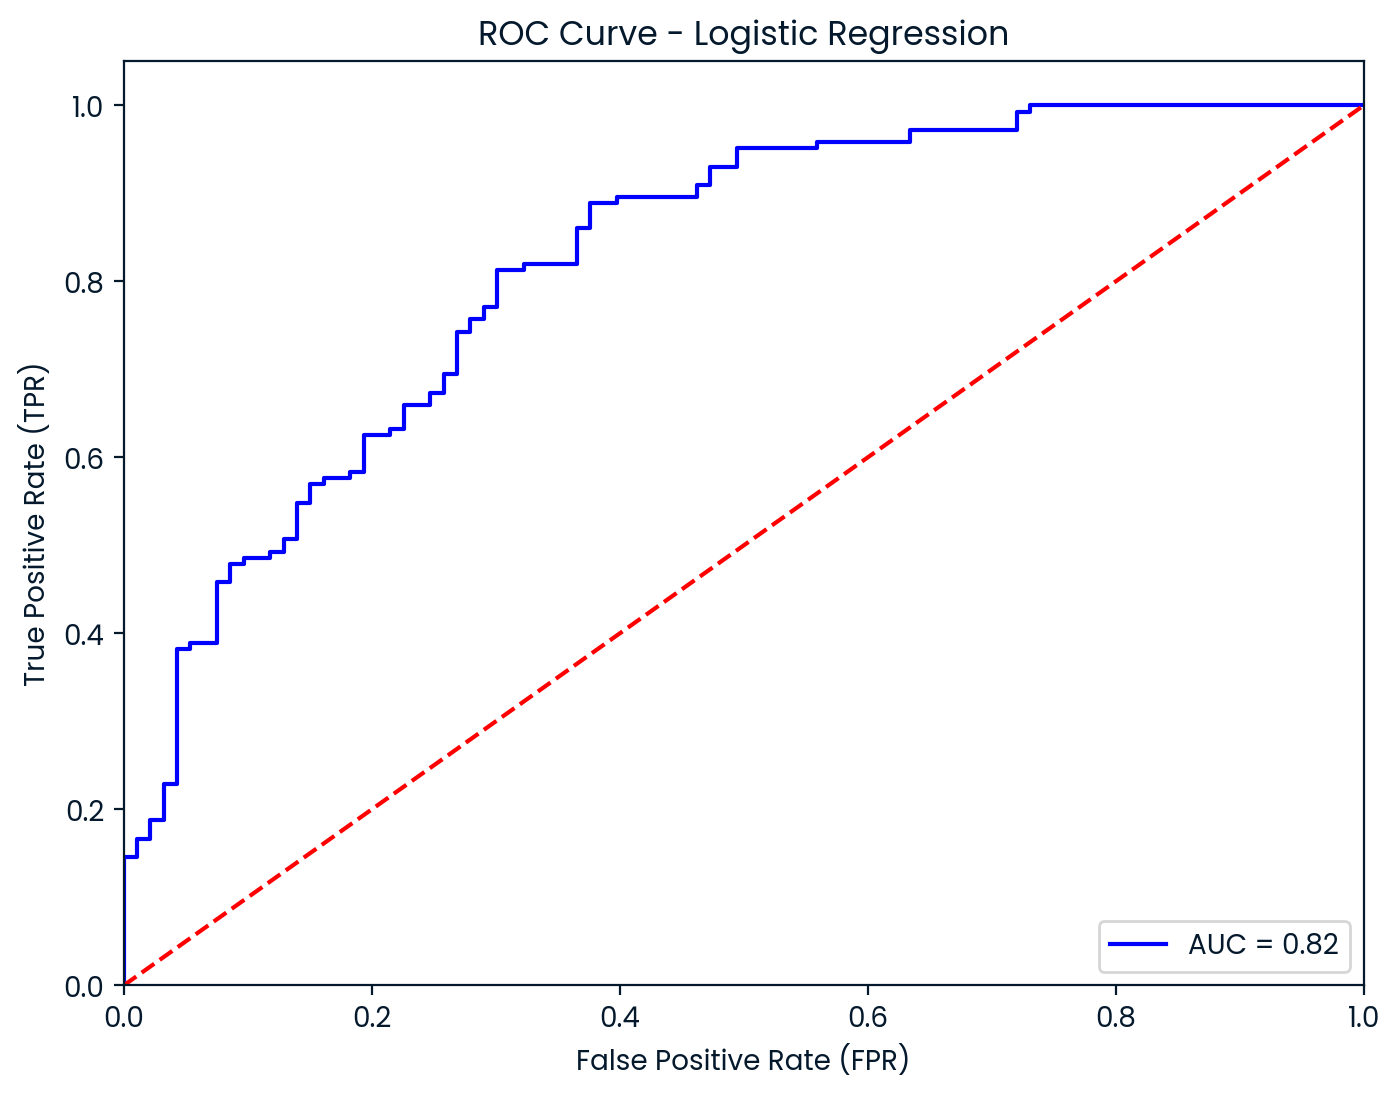

In [183]:
# Predict the probabilities for the positive class (class 1)
y_prob_log_reg = simple_log_reg_pipeline.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log_reg)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_prob_log_reg)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

An AUC of 0.82 indicates that the model has good discriminative power and can effectively separate the positive and negative classes.

Finally, let's create a bar graph to illustrate the importance of each feature for the trained model.

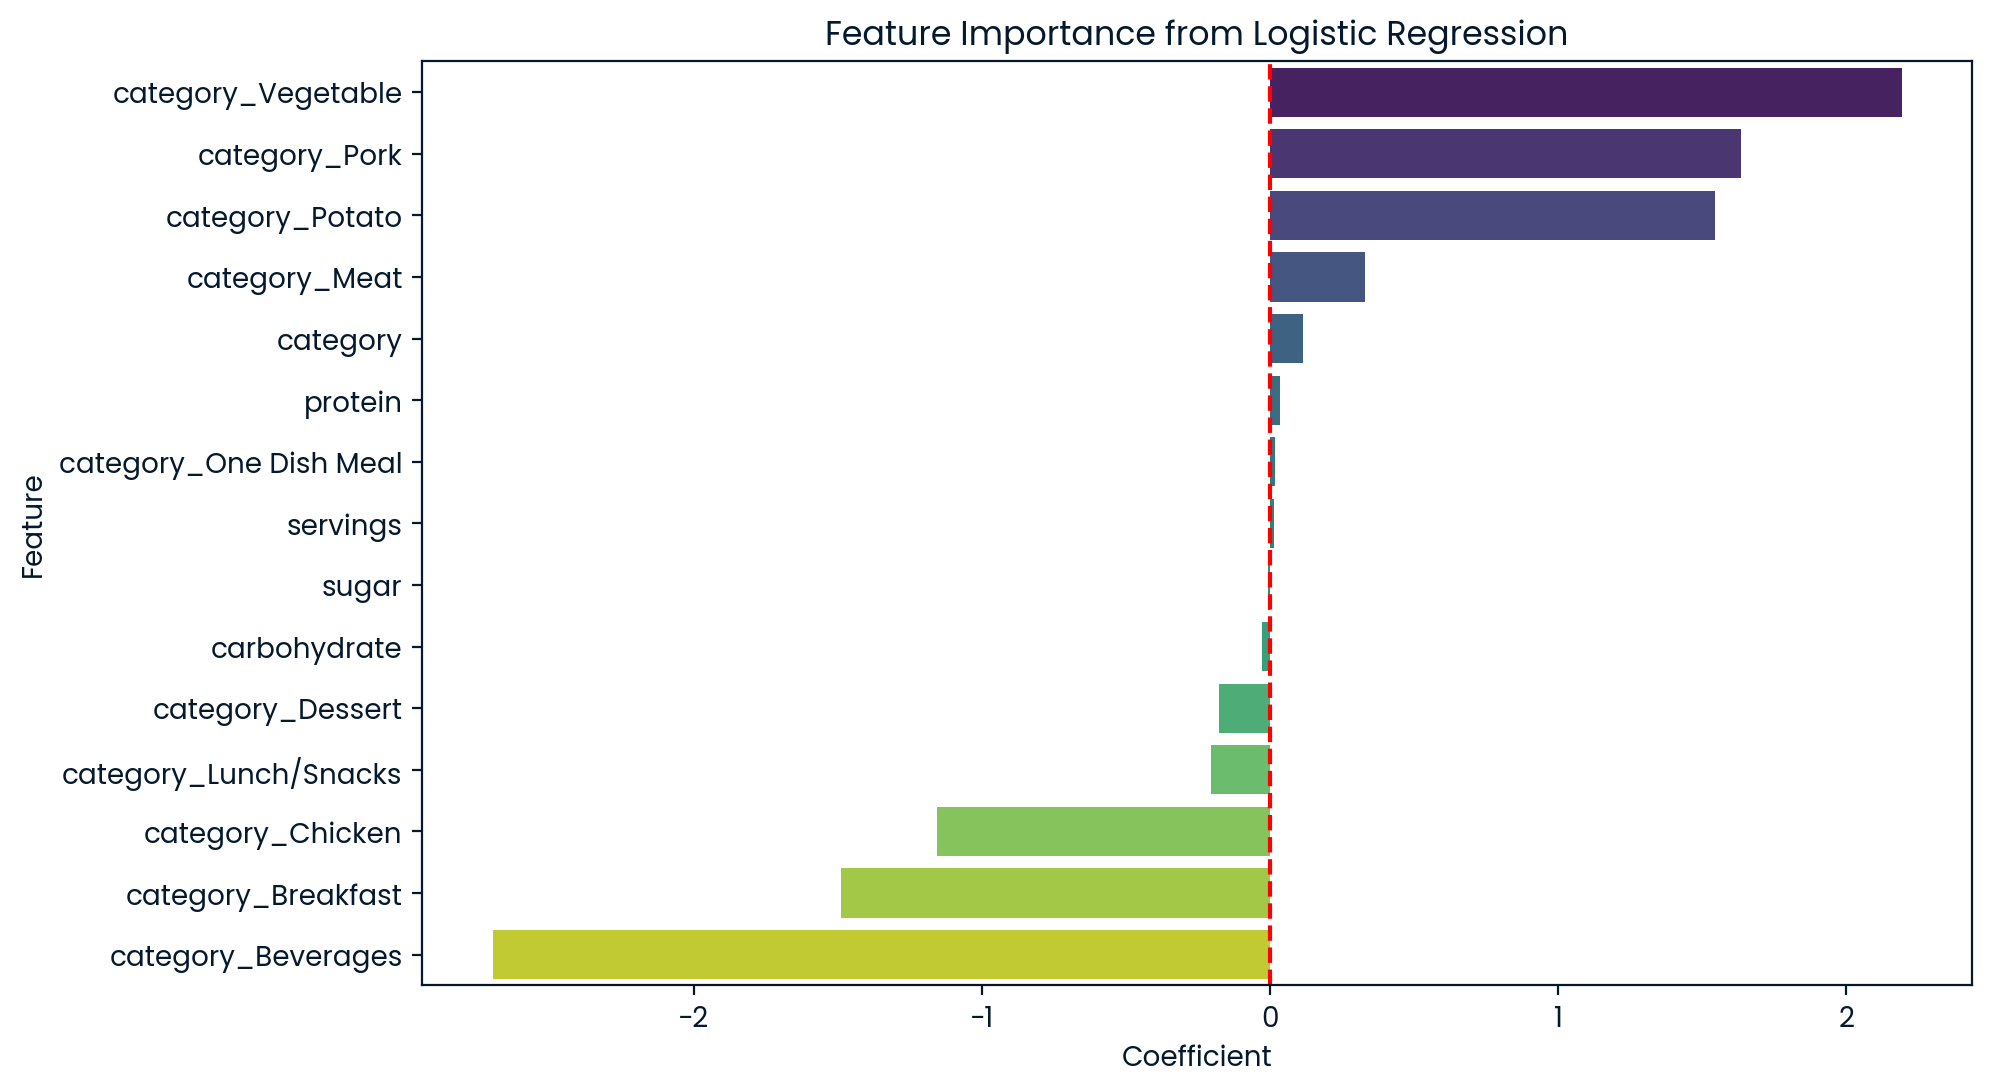

In [184]:
# Access the logistic regression model from the pipeline
log_reg_model = simple_log_reg_pipeline.named_steps['log_reg']

# Extract the preprocessor step
preprocessor = simple_log_reg_pipeline.named_steps['preprocessor']

# Get the coefficients (for binary classification, it will be a 1D array)
coefficients = log_reg_model.coef_[0]

# Access the one-hot encoder from the pipeline
one_hot_encoder = preprocessor.named_transformers_['cat']

# Get one-hot encoded feature names
categorical_feature_names = one_hot_encoder.get_feature_names_out(['category'])

# Concatenate the selected column names and categorical feature names
concatenated_array = np.concatenate((
    np.array(df.columns[1:5]),  # Select columns 1 to 4 (exclusive of the 5th)
    categorical_feature_names,   # Include the categorical feature names
    np.array([df.columns[-2]])   # Last column name (target) as a single element array
))

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': concatenated_array,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.xlabel('Coefficient')
plt.title('Feature Importance from Logistic Regression')
plt.axvline(0, color='red', linestyle='--')  # Add a vertical line at 0 for reference
plt.show()

# Business Metrics

Ideally, it would be great for our company if the homepage always displayed popular recipes to catch the attention of our customers. In machine learning terms, this means achieving a precision score of 1 for the positive class (high-traffic recipes). To approach this goal, we need a model with the highest possible precision score. This is where the simple logistic regression classifier comes in, it can help the product manager improve the selection of popular recipes up to 78%. This, in turn, could lead to increased subscriptions, as customers are more likely to spend time on our website.

Moreover, the model has strong classification power for both classes, ensuring that it won’t misclassify many high-traffic recipes as low-traffic while still achieving the desired precision score.

# Final summary

As for my recommendations, I suggest that the company explore popular recipes not only from our website but also from other sources. A dataset with fewer than 1,000 records is considered small, which can hinder the effective training of models. By obtaining more comprehensive data, we can create even more accurate models that will help generate additional subscriptions.

Additionally, our database contains some recipes with missing information, it would be beneficial to review and fill in these gaps with accurate values. In the future, we should strive to include only those recipes with complete information.

Furthermore, it seems that users do not pay much attention to nutritional information or serving sizes, instead, the type of meal has a greater impact on their preferences. Our analysis indicates that users particularly enjoy recipes featuring vegetables, pork, and potatoes. Therefore, focusing on gathering more recipes of these types could be advantageous for displaying them more frequently. However, this should be approached with caution, as consistently showcasing the same type of recipes might lead to monotony.
